In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D
from scipy.integrate import quad as quad
import sys
sys.path.insert(0, "/scratch/ierez/IGMCosmo/VoidFinder/python/")
#import voidfinder
#from voidfinder import distance
#from voidfinder.distance import z_to_comoving_dist
from astropy import constants as const
from astropy.table import Table

import os
from astropy.io import fits
in_directory='/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/'
os.chdir(in_directory)

## Data files

In [2]:
galaxy_filename = '/scratch/sbenzvi_lab/boss/dr16/delta_fields/deltafields_added90_fixed.fits' #delta_fields
quasars_filename='/scratch/sbenzvi_lab/boss/dr16/delta_fields/quasars.fits'
#void_filename = '/Users/kellydouglass/Documents/Research/Voids/VoidFinder/void_catalogs/SDSS/python_implementation/vollim_dr7_cbp_102709_comoving_maximal.txt'
void_filename = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runsdeltafields_added90_fixed._comoving_maximal_noMagCut.txt'

## Import data

In [3]:
# Galaxy catalog
#galaxies = Table.read(galaxy_filename, format='ascii.commented_header', 
#                      include_names=['ra', 'dec', 'redshift', 'Rgal', 'vflag'])
galaxies = fits.open(galaxy_filename)  
galaxies=Table(galaxies[1].data)
galaxies['z'].name='redshift'
#rgal=Table.Column(1*np.ones(len(galaxies['ra'])), name='Rgal')
#galaxies.add_column(rgal)
vflag=Table.Column(np.zeros(len(galaxies['ra'])), name='vflag')
galaxies.add_column(vflag)
# Void catalog (detected voids, output of voidfinder)
voids = Table.read(void_filename, format='ascii.commented_header')

quasars = fits.open(quasars_filename)  
quasars=Table(quasars[1].data)
galaxies[0:5]


<Table length=5>
        ra                dec         ...        delta          vflag 
     float64            float64       ...       float64        float64
----------------- ------------------- ... -------------------- -------
55.09803355164553 -1.1593308268464853 ...  -2.6700565094875603     0.0
55.09803355164553 -1.1593308268464853 ...  -1.4396249644115322     0.0
55.09803355164553 -1.1593308268464853 ... -0.45740696573626016     0.0
55.09803355164553 -1.1593308268464853 ...    4.137706831117744     0.0
55.09803355164553 -1.1593308268464853 ...    1.155314062862347     0.0

## z to comoving distance

In [4]:
#z to comoving
#voidfinder.distance.z_to_comoving_dist

Omega_M = 0.3147
c = const.c.to('km/s').value
def Distance(z,omega_m = Omega_M,h = 1):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

def f(a,omega_m = Omega_M):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

galaxies['comoving']= Distance(galaxies['redshift'],Omega_M,1)
quasars['comoving']= Distance(quasars['z'],Omega_M,1)
#Continue with voids['r']

## Shift ra's back for all

In [5]:
galaxies['ra'] = galaxies['ra']-90
quasars['ra'] = quasars['ra']-90
voids['ra'] = voids['ra']-90

## Function to set up axes

Following matplotlib demo : https://matplotlib.org/examples/axes_grid/demo_floating_axes.html

In [6]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("Comoving Distance [Mpc/h]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

## Wedge plot

In [7]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get difference slices.
d,s = 0, 0.05 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small.
slice_= d + 0.5*s


################################################################################
# Remove galaxies outside declination range
#-------------------------------------------------------------------------------
galaxies_dec_cut = np.logical_and(galaxies['dec'] > d, 
                                  galaxies['dec'] <= d+s)
galaxies_dec_slice = galaxies[galaxies_dec_cut]
################################################################################


################################################################################
# Remove galaxies outside distance range
#-------------------------------------------------------------------------------
cz_min, cz_max = min(quasars['comoving']), max(quasars['comoving']) #32700

galaxies_dist_boolean = np.logical_and(galaxies_dec_slice['comoving'] > cz_min, 
                                       galaxies_dec_slice['comoving'] <= cz_max)
galaxies_sample = galaxies_dec_slice[galaxies_dist_boolean]
################################################################################


################################################################################
# Voids that intersect the slice
#-------------------------------------------------------------------------------
dec_intersect_cut = np.sin(np.abs(slice_ - voids['dec'])*np.pi/180)*voids['r'] <= voids['radius']
void_sample = voids[dec_intersect_cut]

# Radius of void at intersection
void_sample['radius_intersect'] = np.sqrt(void_sample['radius']**2 
                                          - (np.sin(np.abs(slice_ - void_sample['dec'])*np.pi/180)*void_sample['r'])**2)
################################################################################


################################################################################
# Transform hole centers from (ra, r) to (x, y)
#-------------------------------------------------------------------------------
void_sample['x_polar'] = void_sample['r']*np.cos(void_sample['ra']*np.pi/180 - 0.5*np.pi)
void_sample['y_polar'] = void_sample['r']*np.sin(void_sample['ra']*np.pi/180 - 0.5*np.pi)
################################################################################
max(void_sample['x_polar'])

3155.8682207627476

In [8]:
#divide data to three groups
delta_less=galaxies[galaxies['delta']<-0.2]
delta_more=galaxies[galaxies['delta']>0.2]
delta_mid=galaxies[galaxies['delta']<=0.2]
delta_mid=delta_mid[delta_mid['delta']>=-0.2]
delta_mid[0:5]

<Table length=5>
        ra                 dec         ...  vflag       comoving     
     float64             float64       ... float64      float64      
------------------ ------------------- ... ------- ------------------
-34.90196644835447 -1.1593308268464853 ...     0.0  4469.781711234806
-34.90196644835447 -1.1593308268464853 ...     0.0  4483.481234470765
-34.90196644835447 -1.1593308268464853 ...     0.0  4485.860388460116
-34.90196644835447 -1.1593308268464853 ...     0.0  4489.427247044038
-34.90196644835447 -1.1593308268464853 ...     0.0 4508.4125670356225

In [9]:
print(len(delta_mid))
print(len(delta_more))
print(len(delta_less))

1150709
1730926
1525847


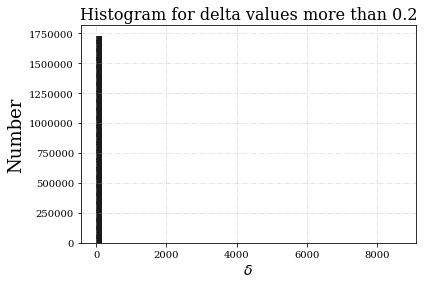

In [21]:
#Histogram of delta values

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values more than 0.2',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(delta_more['delta'] , color=(0.1,0.1,0.1),bins=50)                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

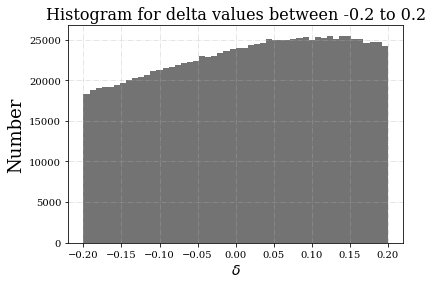

In [19]:
#Histogram of delta values

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values between -0.2 to 0.2',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(delta_mid['delta'] , color=(0.45,0.45,0.45),bins=50)                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

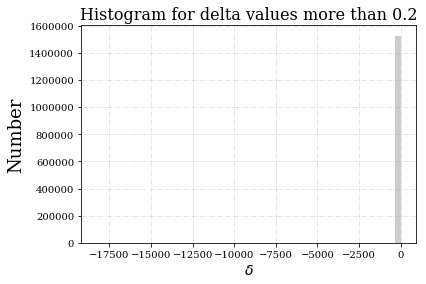

In [22]:
#Histogram of delta values

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values more than 0.2',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(delta_less['delta'] , color=(0.8,0.8,0.8),bins=50)                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

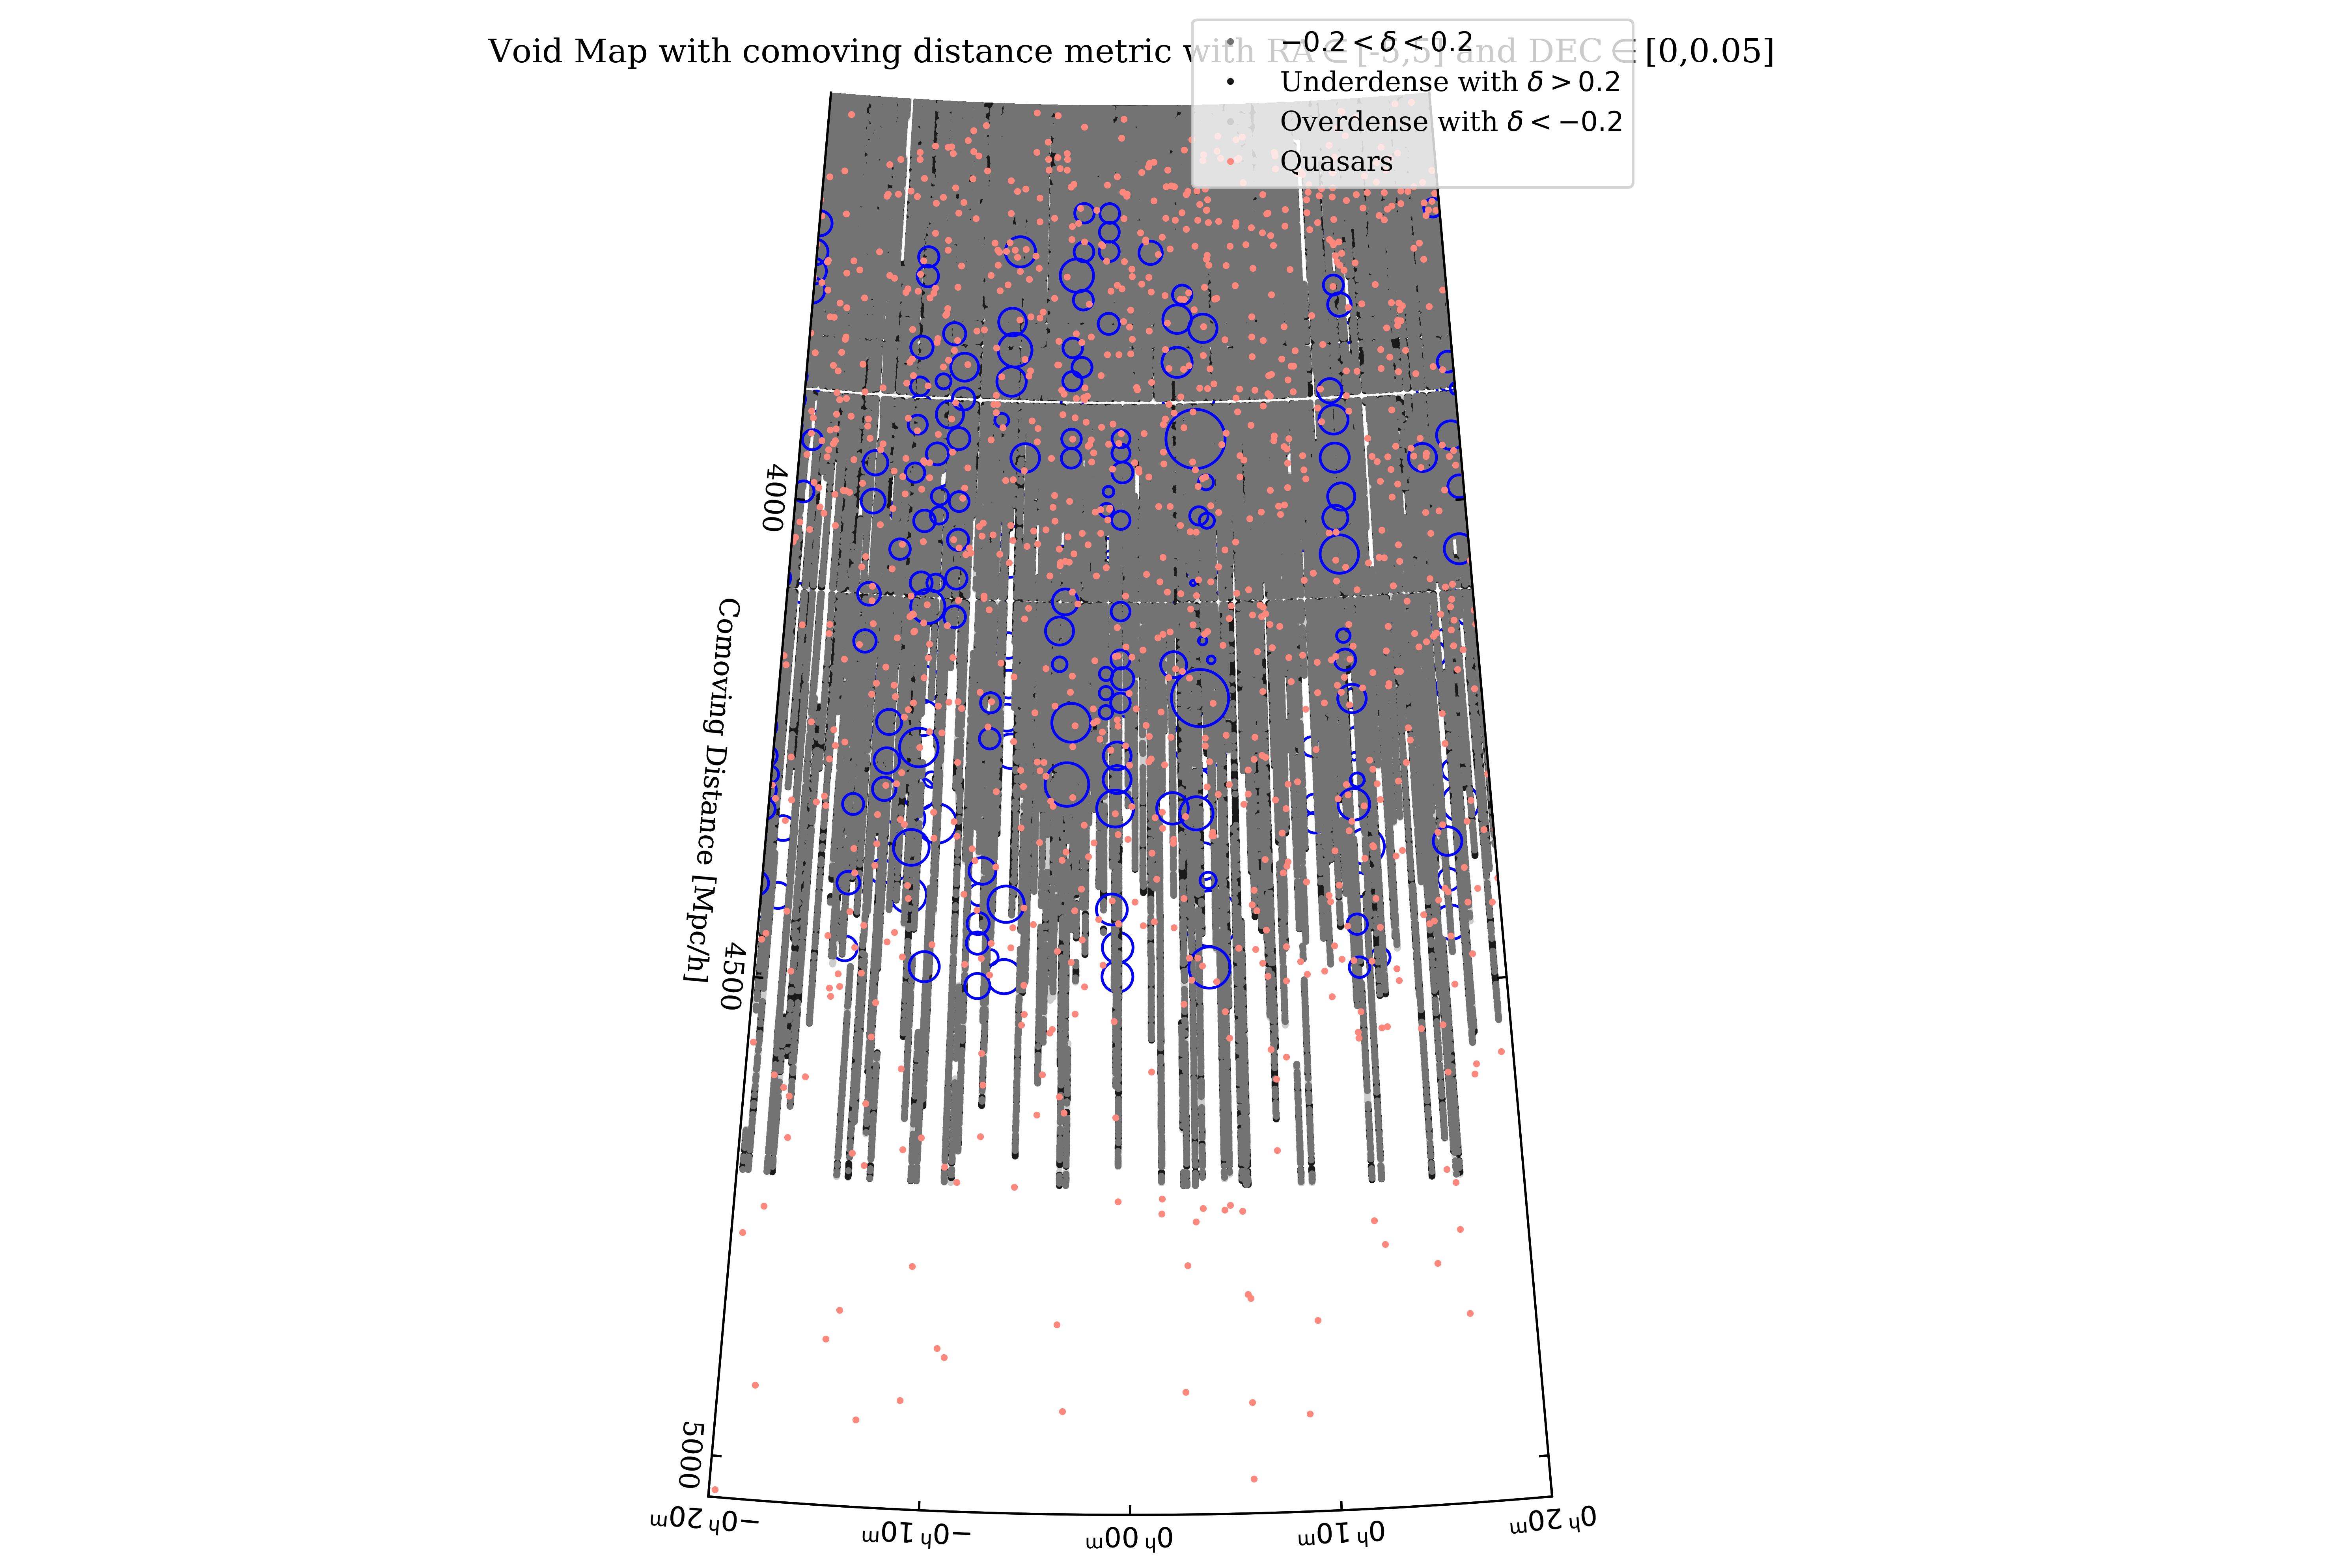

In [71]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -5, 5

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(delta_mid['ra'], 
            delta_mid['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.45,0.45,0.45), ms=3, zorder=1, label='$-0.2<\delta<0.2$')
            #'.', c='0.5', zorder=1, label='Wall')
    
aux_ax.plot(delta_more['ra'], 
            delta_more['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.1,0.1,0.1), ms=3, zorder=1, label='Underdense with $\delta>0.2$')
aux_ax.plot(delta_less['ra'], 
            delta_less['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.8,0.8,0.8), ms=3, zorder=1, label='Overdense with $\delta<-0.2$')

aux_ax.plot(quasars['ra'], 
            quasars['comoving'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)
'''
aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)
'''
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric with RA$\in$['+str(ra_min)+','+str(ra_max)+'] and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

#plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)

In [24]:
len(voids['r'])
quasars[0:5]

<Table length=5>
         ra                 dec                z              comoving    
      float64             float64           float64           float64     
------------------- ------------------- ---------------- -----------------
 -34.90196644835447  -1.159330826846483            3.774  4832.81253150792
-34.692674572422334 -1.0531637172445856            3.446 4657.527770830647
 -34.60865459248191 -0.8345530857219153 2.75148963928223  4215.34429893826
-34.472523569472685 -0.9748963978803513            2.704 4180.800516204877
-34.444164549902894  -1.142452301903663            2.341  3894.00482503552

In [25]:
min(voids['r'])

3684.9573490655125

In [26]:
max(galaxies['delta'])

8665.70026792556

bnorm = []
for i in galaxies['delta']:
    i = i/8665.70026792556   ### normalizing the data
    bnorm.append(i)

In [27]:
len(galaxies[galaxies['delta']<-1])

500994

bnorm = []
for i in galaxies['delta']:
    i = (i-(-18291.021180129555))/8665.70026792556   ### normalizing the data
    bnorm.append(i)

max(bnorm)
for i in range(len(bnorm)):
    bnorm[i] = bnorm[i]/3.110737807056435 ### normalizing the data

In [28]:
max(bnorm)

NameError: name 'bnorm' is not defined

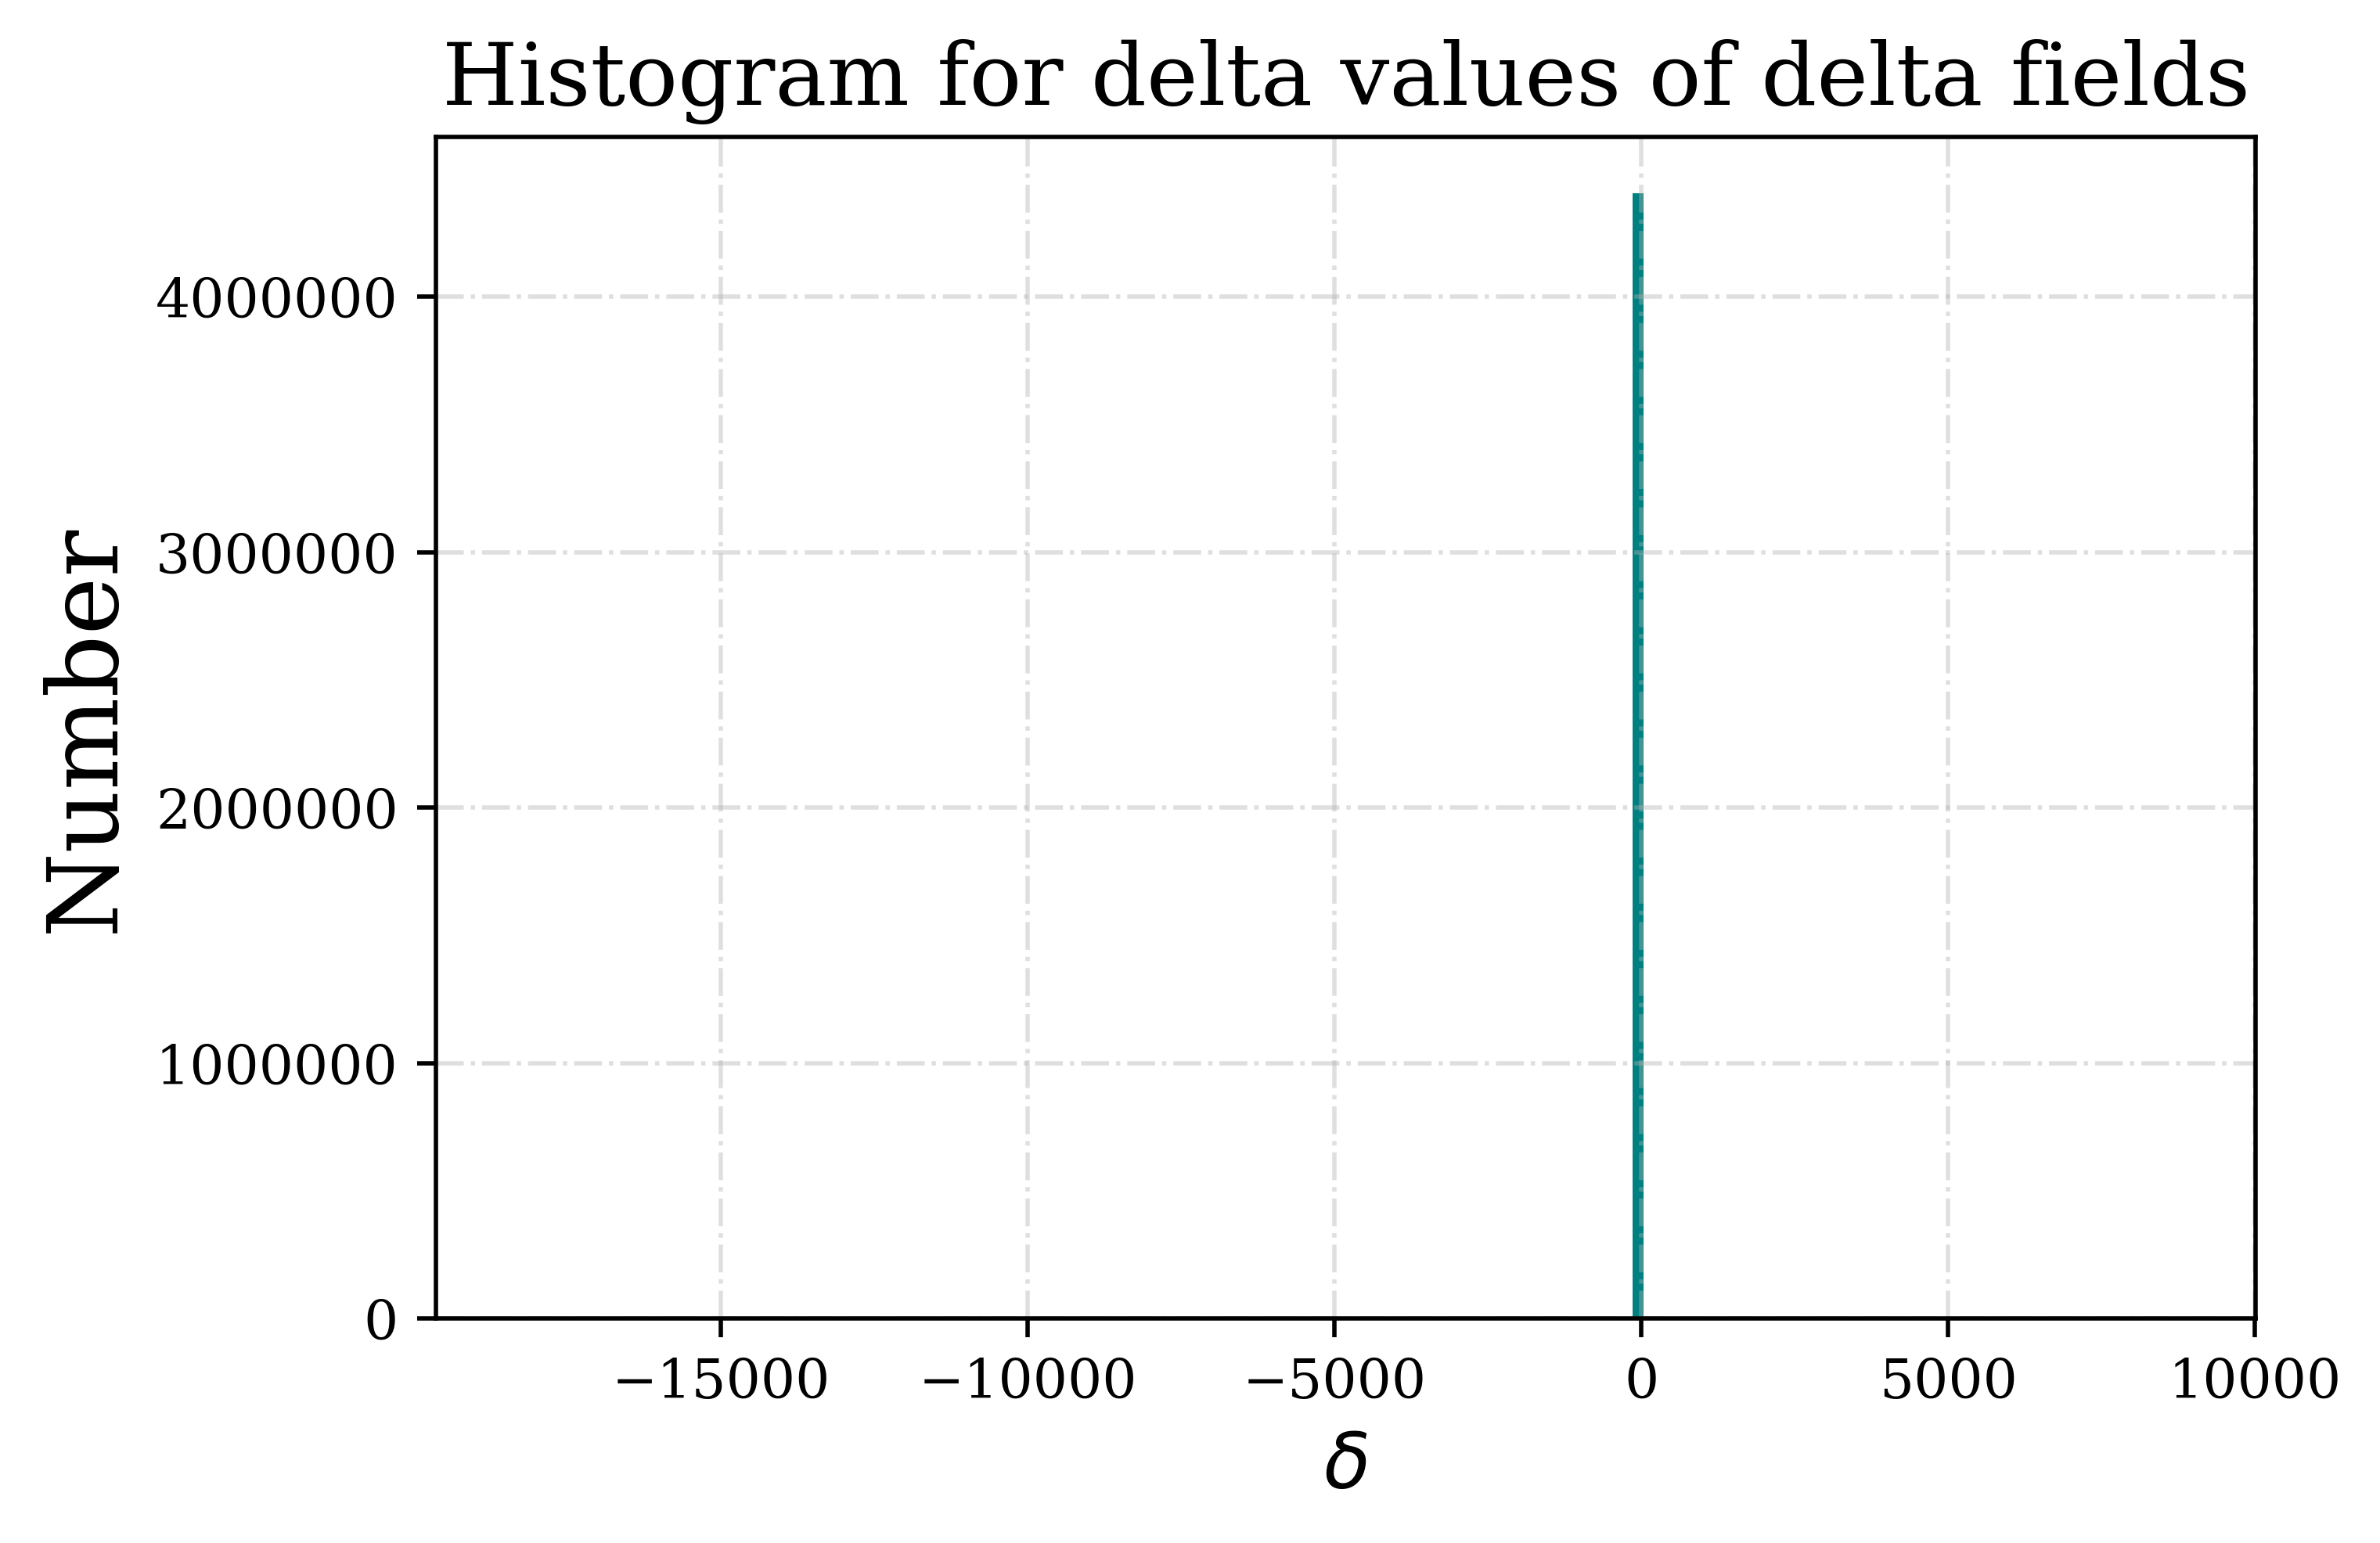

In [32]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values of delta fields',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(galaxies['delta'] , color='teal',bins=150)                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [33]:
min(galaxies['delta'])

-18291.021180129555

In [34]:
max(galaxies['delta'])

8665.70026792556

In [35]:
np.mean(galaxies['delta'])

0.07053437545511478

In [36]:
np.median(galaxies['delta'])

0.04894644003050064

## Investigate the spectra

In [306]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/') if isfile(join('/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/', f))]
onlyfiles
onlyfiles.remove('alldeltas_fixed.fits')

In [313]:
for file in onlyfiles:
    d = fits.open('/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/'+file)
    for hdu_num in range(1,len(d)):
        lesss=less_1[less_1['ra'] == d[hdu_num].header['RA']*(180/np.pi)]
        print(len(lesss))
        print(file)
        print(hdu_num)

print(file)

0
delta-356.fits
1
0
delta-356.fits
2
0
delta-356.fits
3
0
delta-356.fits
4
0
delta-356.fits
5
0
delta-356.fits
6
0
delta-356.fits
7
0
delta-356.fits
8
0
delta-356.fits
9
0
delta-356.fits
10
0
delta-356.fits
11
0
delta-356.fits
12
0
delta-356.fits
13
0
delta-356.fits
14
0
delta-356.fits
15
0
delta-356.fits
16
0
delta-356.fits
17
0
delta-356.fits
18
0
delta-356.fits
19
0
delta-356.fits
20
0
delta-356.fits
21
0
delta-356.fits
22
0
delta-356.fits
23
0
delta-356.fits
24
0
delta-356.fits
25
0
delta-356.fits
26
0
delta-356.fits
27
0
delta-356.fits
28
0
delta-356.fits
29
0
delta-356.fits
30
0
delta-429.fits
1
0
delta-429.fits
2
0
delta-429.fits
3
0
delta-429.fits
4
0
delta-429.fits
5
0
delta-429.fits
6
0
delta-429.fits
7
0
delta-429.fits
8
0
delta-429.fits
9
0
delta-429.fits
10
0
delta-429.fits
11
0
delta-429.fits
12
0
delta-429.fits
13
0
delta-429.fits
14
0
delta-429.fits
15
0
delta-429.fits
16
0
delta-429.fits
17
0
delta-429.fits
18
0
delta-429.fits
19
0
delta-429.fits
20
0
delta-429.fits
2

2
delta-371.fits
234
16
delta-371.fits
235
0
delta-371.fits
236
0
delta-371.fits
237
0
delta-371.fits
238
95
delta-371.fits
239
0
delta-371.fits
240
0
delta-371.fits
241
0
delta-371.fits
242
0
delta-371.fits
243
0
delta-371.fits
244
0
delta-371.fits
245
0
delta-371.fits
246
0
delta-371.fits
247
17
delta-371.fits
248
0
delta-371.fits
249
81
delta-371.fits
250
10
delta-371.fits
251
0
delta-371.fits
252
3
delta-371.fits
253
0
delta-371.fits
254
0
delta-371.fits
255
0
delta-371.fits
256
0
delta-371.fits
257
76
delta-371.fits
258
0
delta-371.fits
259
118
delta-371.fits
260
54
delta-371.fits
261
40
delta-371.fits
262
0
delta-371.fits
263
0
delta-371.fits
264
103
delta-371.fits
265
65
delta-371.fits
266
0
delta-371.fits
267
1
delta-371.fits
268
0
delta-371.fits
269
0
delta-371.fits
270
0
delta-371.fits
271
0
delta-371.fits
272
57
delta-371.fits
273
0
delta-371.fits
274
0
delta-371.fits
275
0
delta-371.fits
276
90
delta-371.fits
277
21
delta-371.fits
278
80
delta-371.fits
279
0
delta-371.fits


54
delta-371.fits
654
40
delta-371.fits
655
0
delta-371.fits
656
0
delta-371.fits
657
0
delta-371.fits
658
3
delta-371.fits
659
0
delta-371.fits
660
1
delta-371.fits
661
0
delta-371.fits
662
0
delta-371.fits
663
45
delta-371.fits
664
46
delta-371.fits
665
0
delta-371.fits
666
10
delta-371.fits
667
0
delta-371.fits
668
0
delta-371.fits
669
0
delta-371.fits
670
98
delta-371.fits
671
0
delta-371.fits
672
0
delta-371.fits
673
0
delta-371.fits
674
0
delta-371.fits
675
0
delta-371.fits
676
5
delta-371.fits
677
12
delta-371.fits
678
0
delta-371.fits
679
122
delta-371.fits
680
0
delta-371.fits
681
109
delta-371.fits
682
0
delta-371.fits
683
1
delta-371.fits
684
2
delta-371.fits
685
0
delta-371.fits
686
21
delta-371.fits
687
177
delta-371.fits
688
0
delta-371.fits
689
0
delta-371.fits
690
0
delta-371.fits
691
152
delta-371.fits
692
93
delta-371.fits
693
0
delta-371.fits
694
0
delta-371.fits
695
0
delta-371.fits
696
0
delta-371.fits
697
0
delta-371.fits
698
24
delta-371.fits
699
0
delta-371.fits

0
delta-371.fits
1078
0
delta-371.fits
1079
0
delta-371.fits
1080
0
delta-371.fits
1081
0
delta-371.fits
1082
2
delta-371.fits
1083
0
delta-371.fits
1084
0
delta-371.fits
1085
0
delta-371.fits
1086
0
delta-371.fits
1087
0
delta-371.fits
1088
0
delta-371.fits
1089
38
delta-371.fits
1090
0
delta-371.fits
1091
0
delta-371.fits
1092
0
delta-371.fits
1093
0
delta-371.fits
1094
0
delta-371.fits
1095
70
delta-371.fits
1096
0
delta-371.fits
1097
0
delta-371.fits
1098
0
delta-371.fits
1099
0
delta-371.fits
1100
0
delta-371.fits
1101
0
delta-371.fits
1102
0
delta-371.fits
1103
0
delta-371.fits
1104
0
delta-371.fits
1105
0
delta-371.fits
1106
0
delta-371.fits
1107
0
delta-371.fits
1108
0
delta-371.fits
1109
0
delta-371.fits
1110
0
delta-371.fits
1111
0
delta-371.fits
1112
60
delta-371.fits
1113
33
delta-371.fits
1114
0
delta-371.fits
1115
0
delta-371.fits
1116
0
delta-371.fits
1117
0
delta-371.fits
1118
0
delta-371.fits
1119
0
delta-371.fits
1120
0
delta-371.fits
1121
0
delta-371.fits
1122
0
delt

0
delta-396.fits
301
0
delta-396.fits
302
0
delta-396.fits
303
0
delta-396.fits
304
0
delta-396.fits
305
0
delta-396.fits
306
0
delta-396.fits
307
0
delta-396.fits
308
0
delta-396.fits
309
0
delta-396.fits
310
0
delta-396.fits
311
0
delta-396.fits
312
0
delta-396.fits
313
0
delta-396.fits
314
0
delta-396.fits
315
0
delta-396.fits
316
0
delta-396.fits
317
0
delta-396.fits
318
0
delta-396.fits
319
0
delta-396.fits
320
0
delta-396.fits
321
0
delta-396.fits
322
0
delta-396.fits
323
0
delta-396.fits
324
0
delta-396.fits
325
0
delta-396.fits
326
0
delta-396.fits
327
0
delta-396.fits
328
0
delta-396.fits
329
0
delta-396.fits
330
0
delta-396.fits
331
0
delta-396.fits
332
0
delta-396.fits
333
0
delta-396.fits
334
0
delta-396.fits
335
0
delta-396.fits
336
0
delta-396.fits
337
0
delta-396.fits
338
0
delta-396.fits
339
0
delta-396.fits
340
0
delta-396.fits
341
0
delta-396.fits
342
0
delta-396.fits
343
0
delta-396.fits
344
0
delta-396.fits
345
0
delta-396.fits
346
0
delta-396.fits
347
0
delta-396.f

0
delta-396.fits
814
0
delta-396.fits
815
0
delta-396.fits
816
0
delta-396.fits
817
0
delta-396.fits
818
0
delta-396.fits
819
0
delta-396.fits
820
0
delta-396.fits
821
0
delta-396.fits
822
0
delta-396.fits
823
0
delta-396.fits
824
0
delta-396.fits
825
0
delta-396.fits
826
0
delta-396.fits
827
0
delta-396.fits
828
0
delta-396.fits
829
0
delta-396.fits
830
0
delta-396.fits
831
0
delta-396.fits
832
0
delta-396.fits
833
0
delta-396.fits
834
0
delta-396.fits
835
0
delta-396.fits
836
0
delta-396.fits
837
0
delta-396.fits
838
0
delta-396.fits
839
0
delta-396.fits
840
0
delta-396.fits
841
0
delta-396.fits
842
0
delta-396.fits
843
0
delta-396.fits
844
0
delta-396.fits
845
0
delta-396.fits
846
0
delta-396.fits
847
0
delta-396.fits
848
0
delta-396.fits
849
0
delta-396.fits
850
0
delta-396.fits
851
0
delta-396.fits
852
0
delta-396.fits
853
0
delta-396.fits
854
0
delta-396.fits
855
0
delta-396.fits
856
0
delta-396.fits
857
0
delta-396.fits
858
0
delta-396.fits
859
0
delta-396.fits
860
0
delta-396.f

0
delta-351.fits
1
0
delta-351.fits
2
0
delta-351.fits
3
0
delta-351.fits
4
0
delta-351.fits
5
0
delta-351.fits
6
0
delta-351.fits
7
0
delta-351.fits
8
0
delta-351.fits
9
0
delta-351.fits
10
0
delta-351.fits
11
0
delta-351.fits
12
0
delta-351.fits
13
0
delta-351.fits
14
0
delta-351.fits
15
0
delta-351.fits
16
0
delta-351.fits
17
0
delta-382.fits
1
0
delta-382.fits
2
0
delta-382.fits
3
0
delta-382.fits
4
0
delta-382.fits
5
0
delta-382.fits
6
0
delta-382.fits
7
0
delta-382.fits
8
0
delta-382.fits
9
0
delta-382.fits
10
0
delta-382.fits
11
0
delta-382.fits
12
0
delta-382.fits
13
0
delta-382.fits
14
0
delta-382.fits
15
0
delta-382.fits
16
0
delta-382.fits
17
0
delta-382.fits
18
0
delta-382.fits
19
0
delta-382.fits
20
0
delta-382.fits
21
0
delta-382.fits
22
0
delta-382.fits
23
0
delta-382.fits
24
0
delta-382.fits
25
0
delta-382.fits
26
0
delta-382.fits
27
0
delta-382.fits
28
0
delta-382.fits
29
0
delta-382.fits
30
0
delta-382.fits
31
0
delta-382.fits
32
0
delta-382.fits
33
0
delta-382.fits
3

0
delta-387.fits
1
0
delta-387.fits
2
0
delta-387.fits
3
0
delta-387.fits
4
0
delta-387.fits
5
0
delta-387.fits
6
0
delta-387.fits
7
0
delta-387.fits
8
0
delta-387.fits
9
0
delta-387.fits
10
0
delta-387.fits
11
0
delta-387.fits
12
0
delta-387.fits
13
0
delta-387.fits
14
0
delta-387.fits
15
0
delta-387.fits
16
0
delta-387.fits
17
0
delta-387.fits
18
0
delta-387.fits
19
0
delta-387.fits
20
0
delta-387.fits
21
0
delta-387.fits
22
0
delta-387.fits
23
0
delta-387.fits
24
0
delta-387.fits
25
0
delta-387.fits
26
0
delta-387.fits
27
0
delta-387.fits
28
0
delta-387.fits
29
0
delta-387.fits
30
0
delta-387.fits
31
0
delta-387.fits
32
0
delta-387.fits
33
0
delta-387.fits
34
0
delta-387.fits
35
0
delta-387.fits
36
0
delta-387.fits
37
0
delta-387.fits
38
0
delta-387.fits
39
0
delta-387.fits
40
0
delta-387.fits
41
0
delta-387.fits
42
0
delta-387.fits
43
0
delta-387.fits
44
0
delta-387.fits
45
0
delta-387.fits
46
0
delta-387.fits
47
0
delta-387.fits
48
0
delta-387.fits
49
0
delta-387.fits
50
0
delta-3

0
delta-401.fits
43
0
delta-401.fits
44
0
delta-401.fits
45
0
delta-401.fits
46
0
delta-401.fits
47
0
delta-401.fits
48
0
delta-401.fits
49
0
delta-401.fits
50
0
delta-401.fits
51
0
delta-401.fits
52
0
delta-401.fits
53
0
delta-401.fits
54
0
delta-401.fits
55
0
delta-401.fits
56
0
delta-401.fits
57
0
delta-401.fits
58
0
delta-401.fits
59
0
delta-401.fits
60
0
delta-401.fits
61
140
delta-401.fits
62
0
delta-401.fits
63
0
delta-401.fits
64
0
delta-401.fits
65
1
delta-401.fits
66
0
delta-401.fits
67
0
delta-401.fits
68
0
delta-401.fits
69
0
delta-401.fits
70
0
delta-401.fits
71
0
delta-401.fits
72
0
delta-401.fits
73
0
delta-401.fits
74
0
delta-401.fits
75
0
delta-401.fits
76
0
delta-401.fits
77
0
delta-401.fits
78
40
delta-401.fits
79
85
delta-401.fits
80
0
delta-401.fits
81
0
delta-401.fits
82
0
delta-401.fits
83
0
delta-401.fits
84
15
delta-401.fits
85
0
delta-401.fits
86
0
delta-401.fits
87
0
delta-401.fits
88
0
delta-401.fits
89
0
delta-401.fits
90
0
delta-401.fits
91
0
delta-401.fit

0
delta-369.fits
434
0
delta-369.fits
435
106
delta-369.fits
436
79
delta-369.fits
437
4
delta-369.fits
438
0
delta-369.fits
439
0
delta-369.fits
440
35
delta-369.fits
441
0
delta-369.fits
442
0
delta-369.fits
443
73
delta-369.fits
444
0
delta-369.fits
445
0
delta-369.fits
446
0
delta-369.fits
447
6
delta-369.fits
448
0
delta-369.fits
449
0
delta-369.fits
450
0
delta-369.fits
451
0
delta-369.fits
452
0
delta-369.fits
453
0
delta-369.fits
454
0
delta-369.fits
455
0
delta-369.fits
456
0
delta-369.fits
457
0
delta-369.fits
458
0
delta-369.fits
459
0
delta-369.fits
460
0
delta-369.fits
461
0
delta-369.fits
462
0
delta-369.fits
463
0
delta-369.fits
464
0
delta-369.fits
465
0
delta-369.fits
466
0
delta-369.fits
467
0
delta-369.fits
468
4
delta-369.fits
469
0
delta-369.fits
470
0
delta-369.fits
471
0
delta-369.fits
472
0
delta-369.fits
473
0
delta-369.fits
474
109
delta-369.fits
475
0
delta-369.fits
476
0
delta-369.fits
477
0
delta-369.fits
478
1
delta-369.fits
479
0
delta-369.fits
480
0
delt

0
delta-369.fits
896
133
delta-369.fits
897
24
delta-369.fits
898
11
delta-369.fits
899
0
delta-369.fits
900
0
delta-369.fits
901
0
delta-369.fits
902
0
delta-369.fits
903
0
delta-369.fits
904
124
delta-369.fits
905
0
delta-369.fits
906
0
delta-369.fits
907
0
delta-369.fits
908
0
delta-369.fits
909
0
delta-369.fits
910
0
delta-369.fits
911
1
delta-369.fits
912
0
delta-369.fits
913
0
delta-369.fits
914
0
delta-369.fits
915
0
delta-369.fits
916
0
delta-369.fits
917
0
delta-369.fits
918
0
delta-369.fits
919
0
delta-369.fits
920
80
delta-369.fits
921
0
delta-369.fits
922
0
delta-369.fits
923
0
delta-369.fits
924
0
delta-369.fits
925
0
delta-369.fits
926
0
delta-369.fits
927
83
delta-369.fits
928
9
delta-369.fits
929
0
delta-369.fits
930
70
delta-369.fits
931
0
delta-369.fits
932
0
delta-369.fits
933
0
delta-369.fits
934
0
delta-369.fits
935
0
delta-369.fits
936
0
delta-369.fits
937
0
delta-369.fits
938
0
delta-369.fits
939
0
delta-369.fits
940
0
delta-369.fits
941
14
delta-369.fits
942
0
d

0
delta-380.fits
1
0
delta-380.fits
2
0
delta-380.fits
3
0
delta-380.fits
4
0
delta-380.fits
5
0
delta-380.fits
6
0
delta-380.fits
7
0
delta-380.fits
8
0
delta-380.fits
9
0
delta-380.fits
10
0
delta-380.fits
11
0
delta-380.fits
12
0
delta-380.fits
13
0
delta-380.fits
14
0
delta-380.fits
15
0
delta-380.fits
16
0
delta-380.fits
17
0
delta-380.fits
18
0
delta-380.fits
19
0
delta-380.fits
20
0
delta-380.fits
21
0
delta-380.fits
22
0
delta-380.fits
23
0
delta-380.fits
24
0
delta-380.fits
25
0
delta-380.fits
26
0
delta-380.fits
27
0
delta-380.fits
28
0
delta-380.fits
29
0
delta-380.fits
30
0
delta-380.fits
31
0
delta-380.fits
32
0
delta-380.fits
33
0
delta-380.fits
34
0
delta-380.fits
35
0
delta-380.fits
36
0
delta-380.fits
37
0
delta-380.fits
38
0
delta-380.fits
39
0
delta-380.fits
40
0
delta-380.fits
41
0
delta-380.fits
42
0
delta-380.fits
43
0
delta-380.fits
44
0
delta-380.fits
45
0
delta-380.fits
46
0
delta-380.fits
47
0
delta-380.fits
48
0
delta-380.fits
49
0
delta-380.fits
50
0
delta-3

0
delta-379.fits
1
0
delta-379.fits
2
0
delta-379.fits
3
0
delta-379.fits
4
0
delta-379.fits
5
0
delta-379.fits
6
0
delta-379.fits
7
0
delta-379.fits
8
0
delta-379.fits
9
0
delta-379.fits
10
0
delta-379.fits
11
0
delta-379.fits
12
0
delta-379.fits
13
0
delta-379.fits
14
0
delta-379.fits
15
0
delta-379.fits
16
0
delta-379.fits
17
0
delta-379.fits
18
0
delta-379.fits
19
0
delta-379.fits
20
0
delta-379.fits
21
0
delta-379.fits
22
0
delta-379.fits
23
0
delta-379.fits
24
0
delta-379.fits
25
0
delta-379.fits
26
0
delta-379.fits
27
0
delta-379.fits
28
0
delta-379.fits
29
0
delta-379.fits
30
0
delta-379.fits
31
0
delta-379.fits
32
0
delta-379.fits
33
0
delta-379.fits
34
0
delta-379.fits
35
0
delta-379.fits
36
0
delta-379.fits
37
0
delta-379.fits
38
0
delta-379.fits
39
0
delta-379.fits
40
0
delta-379.fits
41
0
delta-379.fits
42
0
delta-379.fits
43
0
delta-379.fits
44
0
delta-379.fits
45
0
delta-379.fits
46
0
delta-379.fits
47
0
delta-379.fits
48
0
delta-379.fits
49
0
delta-379.fits
50
0
delta-3

0
delta-413.fits
11
0
delta-413.fits
12
0
delta-413.fits
13
0
delta-413.fits
14
0
delta-413.fits
15
0
delta-413.fits
16
0
delta-413.fits
17
0
delta-413.fits
18
0
delta-413.fits
19
0
delta-413.fits
20
0
delta-357.fits
1
0
delta-357.fits
2
0
delta-357.fits
3
0
delta-357.fits
4
0
delta-357.fits
5
0
delta-357.fits
6
0
delta-357.fits
7
0
delta-357.fits
8
0
delta-357.fits
9
0
delta-357.fits
10
0
delta-357.fits
11
0
delta-357.fits
12
0
delta-357.fits
13
0
delta-357.fits
14
0
delta-357.fits
15
0
delta-357.fits
16
0
delta-357.fits
17
0
delta-357.fits
18
0
delta-357.fits
19
0
delta-357.fits
20
0
delta-383.fits
1
0
delta-383.fits
2
0
delta-383.fits
3
0
delta-383.fits
4
0
delta-383.fits
5
0
delta-383.fits
6
0
delta-383.fits
7
0
delta-383.fits
8
0
delta-383.fits
9
0
delta-383.fits
10
0
delta-383.fits
11
0
delta-383.fits
12
0
delta-383.fits
13
0
delta-383.fits
14
0
delta-383.fits
15
0
delta-383.fits
16
0
delta-383.fits
17
0
delta-383.fits
18
0
delta-383.fits
19
0
delta-383.fits
20
0
delta-383.fits
2

0
delta-366.fits
21
0
delta-366.fits
22
0
delta-366.fits
23
0
delta-366.fits
24
0
delta-366.fits
25
0
delta-366.fits
26
0
delta-366.fits
27
0
delta-366.fits
28
0
delta-366.fits
29
0
delta-366.fits
30
0
delta-366.fits
31
0
delta-366.fits
32
0
delta-366.fits
33
0
delta-366.fits
34
0
delta-366.fits
35
0
delta-366.fits
36
0
delta-366.fits
37
0
delta-366.fits
38
0
delta-366.fits
39
0
delta-366.fits
40
0
delta-366.fits
41
0
delta-366.fits
42
0
delta-366.fits
43
0
delta-366.fits
44
0
delta-366.fits
45
0
delta-366.fits
46
0
delta-366.fits
47
0
delta-366.fits
48
0
delta-366.fits
49
0
delta-366.fits
50
0
delta-366.fits
51
0
delta-366.fits
52
0
delta-366.fits
53
0
delta-366.fits
54
0
delta-366.fits
55
0
delta-366.fits
56
0
delta-366.fits
57
0
delta-366.fits
58
0
delta-366.fits
59
0
delta-366.fits
60
0
delta-366.fits
61
0
delta-366.fits
62
0
delta-366.fits
63
0
delta-366.fits
64
0
delta-366.fits
65
0
delta-366.fits
66
0
delta-366.fits
67
0
delta-366.fits
68
0
delta-366.fits
69
0
delta-366.fits
70


0
delta-415.fits
1
0
delta-415.fits
2
0
delta-415.fits
3
0
delta-415.fits
4
0
delta-415.fits
5
0
delta-415.fits
6
0
delta-415.fits
7
0
delta-415.fits
8
0
delta-415.fits
9
0
delta-415.fits
10
0
delta-415.fits
11
0
delta-415.fits
12
0
delta-415.fits
13
0
delta-415.fits
14
0
delta-415.fits
15
0
delta-415.fits
16
0
delta-415.fits
17
0
delta-415.fits
18
0
delta-415.fits
19
0
delta-415.fits
20
0
delta-415.fits
21
0
delta-415.fits
22
0
delta-415.fits
23
0
delta-415.fits
24
0
delta-415.fits
25
0
delta-415.fits
26
0
delta-415.fits
27
0
delta-415.fits
28
0
delta-417.fits
1
0
delta-417.fits
2
0
delta-417.fits
3
0
delta-417.fits
4
0
delta-417.fits
5
0
delta-417.fits
6
0
delta-417.fits
7
0
delta-417.fits
8
0
delta-417.fits
9
0
delta-417.fits
10
0
delta-417.fits
11
0
delta-417.fits
12
0
delta-417.fits
13
0
delta-417.fits
14
0
delta-417.fits
15
0
delta-417.fits
16
0
delta-417.fits
17
0
delta-417.fits
18
0
delta-417.fits
19
0
delta-417.fits
20
0
delta-417.fits
21
0
delta-417.fits
22
0
delta-417.fits
2

0
delta-388.fits
158
0
delta-388.fits
159
0
delta-388.fits
160
0
delta-388.fits
161
0
delta-388.fits
162
0
delta-388.fits
163
0
delta-388.fits
164
0
delta-388.fits
165
0
delta-388.fits
166
0
delta-388.fits
167
0
delta-388.fits
168
0
delta-388.fits
169
0
delta-388.fits
170
0
delta-388.fits
171
0
delta-388.fits
172
0
delta-388.fits
173
0
delta-388.fits
174
0
delta-388.fits
175
0
delta-388.fits
176
0
delta-388.fits
177
0
delta-388.fits
178
0
delta-388.fits
179
0
delta-388.fits
180
0
delta-388.fits
181
0
delta-388.fits
182
0
delta-388.fits
183
0
delta-388.fits
184
0
delta-388.fits
185
0
delta-388.fits
186
0
delta-388.fits
187
0
delta-388.fits
188
0
delta-388.fits
189
0
delta-388.fits
190
0
delta-388.fits
191
0
delta-388.fits
192
0
delta-388.fits
193
0
delta-388.fits
194
0
delta-388.fits
195
0
delta-388.fits
196
0
delta-388.fits
197
0
delta-388.fits
198
0
delta-388.fits
199
0
delta-388.fits
200
0
delta-388.fits
201
0
delta-388.fits
202
0
delta-388.fits
203
0
delta-388.fits
204
0
delta-388.f

0
delta-385.fits
321
0
delta-385.fits
322
0
delta-385.fits
323
0
delta-385.fits
324
0
delta-385.fits
325
0
delta-385.fits
326
0
delta-385.fits
327
0
delta-385.fits
328
0
delta-385.fits
329
0
delta-385.fits
330
0
delta-385.fits
331
0
delta-385.fits
332
0
delta-385.fits
333
0
delta-385.fits
334
0
delta-385.fits
335
0
delta-385.fits
336
0
delta-385.fits
337
0
delta-385.fits
338
0
delta-385.fits
339
0
delta-385.fits
340
0
delta-385.fits
341
0
delta-385.fits
342
0
delta-385.fits
343
0
delta-385.fits
344
0
delta-385.fits
345
0
delta-385.fits
346
0
delta-385.fits
347
0
delta-385.fits
348
0
delta-385.fits
349
0
delta-385.fits
350
0
delta-385.fits
351
0
delta-385.fits
352
0
delta-385.fits
353
0
delta-385.fits
354
0
delta-385.fits
355
0
delta-385.fits
356
0
delta-385.fits
357
0
delta-385.fits
358
0
delta-385.fits
359
0
delta-385.fits
360
0
delta-385.fits
361
0
delta-385.fits
362
0
delta-385.fits
363
0
delta-385.fits
364
0
delta-385.fits
365
0
delta-385.fits
366
0
delta-385.fits
367
0
delta-385.f

0
delta-397.fits
395
0
delta-397.fits
396
0
delta-397.fits
397
0
delta-397.fits
398
0
delta-397.fits
399
0
delta-397.fits
400
0
delta-397.fits
401
0
delta-397.fits
402
0
delta-397.fits
403
0
delta-397.fits
404
0
delta-397.fits
405
0
delta-397.fits
406
0
delta-397.fits
407
0
delta-397.fits
408
0
delta-397.fits
409
0
delta-397.fits
410
0
delta-397.fits
411
0
delta-397.fits
412
0
delta-397.fits
413
0
delta-397.fits
414
0
delta-397.fits
415
0
delta-397.fits
416
0
delta-397.fits
417
0
delta-397.fits
418
0
delta-397.fits
419
0
delta-397.fits
420
0
delta-397.fits
421
0
delta-397.fits
422
0
delta-397.fits
423
0
delta-397.fits
424
0
delta-397.fits
425
0
delta-397.fits
426
0
delta-397.fits
427
0
delta-397.fits
428
0
delta-397.fits
429
0
delta-397.fits
430
0
delta-397.fits
431
0
delta-397.fits
432
0
delta-397.fits
433
0
delta-397.fits
434
0
delta-397.fits
435
0
delta-397.fits
436
0
delta-397.fits
437
0
delta-397.fits
438
0
delta-397.fits
439
0
delta-397.fits
440
0
delta-397.fits
441
0
delta-397.f

0
delta-397.fits
891
0
delta-397.fits
892
0
delta-397.fits
893
0
delta-397.fits
894
0
delta-397.fits
895
0
delta-397.fits
896
0
delta-397.fits
897
0
delta-397.fits
898
0
delta-397.fits
899
0
delta-397.fits
900
0
delta-397.fits
901
0
delta-397.fits
902
0
delta-397.fits
903
0
delta-397.fits
904
0
delta-397.fits
905
0
delta-397.fits
906
0
delta-397.fits
907
0
delta-397.fits
908
0
delta-397.fits
909
0
delta-397.fits
910
0
delta-397.fits
911
0
delta-397.fits
912
0
delta-397.fits
913
0
delta-397.fits
914
0
delta-397.fits
915
0
delta-397.fits
916
0
delta-397.fits
917
0
delta-397.fits
918
0
delta-397.fits
919
0
delta-397.fits
920
0
delta-397.fits
921
0
delta-397.fits
922
0
delta-397.fits
923
0
delta-397.fits
924
0
delta-397.fits
925
0
delta-397.fits
926
0
delta-397.fits
927
0
delta-397.fits
928
0
delta-397.fits
929
0
delta-397.fits
930
0
delta-397.fits
931
0
delta-397.fits
932
0
delta-397.fits
933
0
delta-397.fits
934
0
delta-397.fits
935
0
delta-397.fits
936
0
delta-397.fits
937
0
delta-397.f

50
delta-370.fits
169
0
delta-370.fits
170
0
delta-370.fits
171
34
delta-370.fits
172
0
delta-370.fits
173
0
delta-370.fits
174
0
delta-370.fits
175
0
delta-370.fits
176
0
delta-370.fits
177
0
delta-370.fits
178
0
delta-370.fits
179
0
delta-370.fits
180
0
delta-370.fits
181
0
delta-370.fits
182
19
delta-370.fits
183
0
delta-370.fits
184
223
delta-370.fits
185
0
delta-370.fits
186
87
delta-370.fits
187
0
delta-370.fits
188
0
delta-370.fits
189
0
delta-370.fits
190
0
delta-370.fits
191
0
delta-370.fits
192
0
delta-370.fits
193
129
delta-370.fits
194
0
delta-370.fits
195
0
delta-370.fits
196
0
delta-370.fits
197
147
delta-370.fits
198
0
delta-370.fits
199
0
delta-370.fits
200
11
delta-370.fits
201
0
delta-370.fits
202
0
delta-370.fits
203
36
delta-370.fits
204
0
delta-370.fits
205
0
delta-370.fits
206
0
delta-370.fits
207
52
delta-370.fits
208
0
delta-370.fits
209
0
delta-370.fits
210
0
delta-370.fits
211
0
delta-370.fits
212
0
delta-370.fits
213
0
delta-370.fits
214
0
delta-370.fits
215


0
delta-370.fits
677
0
delta-370.fits
678
0
delta-370.fits
679
0
delta-370.fits
680
15
delta-370.fits
681
0
delta-370.fits
682
0
delta-370.fits
683
8
delta-370.fits
684
0
delta-370.fits
685
0
delta-370.fits
686
0
delta-370.fits
687
178
delta-370.fits
688
0
delta-370.fits
689
0
delta-370.fits
690
0
delta-370.fits
691
0
delta-370.fits
692
16
delta-370.fits
693
0
delta-370.fits
694
4
delta-370.fits
695
0
delta-370.fits
696
0
delta-370.fits
697
0
delta-370.fits
698
0
delta-370.fits
699
0
delta-370.fits
700
0
delta-370.fits
701
0
delta-370.fits
702
0
delta-370.fits
703
0
delta-370.fits
704
42
delta-370.fits
705
0
delta-370.fits
706
13
delta-370.fits
707
0
delta-370.fits
708
0
delta-370.fits
709
0
delta-370.fits
710
63
delta-370.fits
711
0
delta-370.fits
712
7
delta-370.fits
713
0
delta-370.fits
714
0
delta-370.fits
715
0
delta-370.fits
716
0
delta-370.fits
717
0
delta-370.fits
718
0
delta-370.fits
719
0
delta-370.fits
720
0
delta-370.fits
721
6
delta-370.fits
722
161
delta-370.fits
723
28
d

82
delta-370.fits
1099
0
delta-370.fits
1100
94
delta-370.fits
1101
4
delta-370.fits
1102
5
delta-370.fits
1103
27
delta-370.fits
1104
5
delta-370.fits
1105
2
delta-370.fits
1106
95
delta-370.fits
1107
0
delta-370.fits
1108
72
delta-370.fits
1109
0
delta-370.fits
1110
61
delta-370.fits
1111
0
delta-370.fits
1112
3
delta-370.fits
1113
0
delta-370.fits
1114
0
delta-370.fits
1115
103
delta-370.fits
1116
49
delta-370.fits
1117
0
delta-370.fits
1118
0
delta-349.fits
1
0
delta-349.fits
2
0
delta-349.fits
3
0
delta-349.fits
4
0
delta-349.fits
5
0
delta-349.fits
6
0
delta-349.fits
7
0
delta-349.fits
8
0
delta-349.fits
9
0
delta-349.fits
10
0
delta-349.fits
11
0
delta-349.fits
12
0
delta-349.fits
13
0
delta-349.fits
14
0
delta-349.fits
15
0
delta-349.fits
16
0
delta-349.fits
17
0
delta-349.fits
18
0
delta-349.fits
19
0
delta-349.fits
20
0
delta-349.fits
21
0
delta-349.fits
22
0
delta-349.fits
23
0
delta-349.fits
24
0
delta-349.fits
25
0
delta-349.fits
26
0
delta-399.fits
1
0
delta-399.fits
2
0


0
delta-399.fits
430
0
delta-399.fits
431
0
delta-399.fits
432
0
delta-399.fits
433
0
delta-399.fits
434
0
delta-399.fits
435
0
delta-399.fits
436
0
delta-399.fits
437
0
delta-399.fits
438
0
delta-399.fits
439
0
delta-399.fits
440
0
delta-399.fits
441
0
delta-399.fits
442
0
delta-399.fits
443
0
delta-399.fits
444
0
delta-399.fits
445
0
delta-399.fits
446
0
delta-399.fits
447
0
delta-399.fits
448
0
delta-399.fits
449
0
delta-399.fits
450
0
delta-399.fits
451
0
delta-399.fits
452
0
delta-399.fits
453
0
delta-399.fits
454
0
delta-399.fits
455
0
delta-399.fits
456
0
delta-399.fits
457
0
delta-399.fits
458
0
delta-399.fits
459
0
delta-399.fits
460
0
delta-399.fits
461
0
delta-399.fits
462
0
delta-399.fits
463
0
delta-399.fits
464
0
delta-399.fits
465
0
delta-399.fits
466
0
delta-399.fits
467
0
delta-399.fits
468
0
delta-399.fits
469
0
delta-399.fits
470
0
delta-399.fits
471
0
delta-399.fits
472
0
delta-399.fits
473
0
delta-399.fits
474
0
delta-399.fits
475
0
delta-399.fits
476
0
delta-399.f

0
delta-399.fits
872
0
delta-399.fits
873
0
delta-399.fits
874
0
delta-399.fits
875
0
delta-399.fits
876
0
delta-399.fits
877
0
delta-399.fits
878
0
delta-399.fits
879
0
delta-399.fits
880
0
delta-399.fits
881
0
delta-399.fits
882
0
delta-399.fits
883
0
delta-399.fits
884
0
delta-399.fits
885
0
delta-399.fits
886
0
delta-399.fits
887
0
delta-399.fits
888
0
delta-399.fits
889
0
delta-399.fits
890
0
delta-399.fits
891
0
delta-399.fits
892
0
delta-399.fits
893
0
delta-399.fits
894
0
delta-399.fits
895
0
delta-399.fits
896
0
delta-399.fits
897
0
delta-399.fits
898
0
delta-399.fits
899
0
delta-399.fits
900
0
delta-399.fits
901
0
delta-399.fits
902
0
delta-399.fits
903
0
delta-399.fits
904
0
delta-399.fits
905
0
delta-399.fits
906
0
delta-399.fits
907
0
delta-399.fits
908
0
delta-399.fits
909
0
delta-399.fits
910
0
delta-399.fits
911
0
delta-399.fits
912
0
delta-399.fits
913
0
delta-399.fits
914
0
delta-399.fits
915
0
delta-399.fits
916
0
delta-399.fits
917
0
delta-399.fits
918
0
delta-399.f

0
delta-381.fits
324
0
delta-381.fits
325
0
delta-381.fits
326
0
delta-381.fits
327
0
delta-381.fits
328
0
delta-381.fits
329
0
delta-381.fits
330
0
delta-381.fits
331
0
delta-381.fits
332
0
delta-381.fits
333
0
delta-381.fits
334
0
delta-381.fits
335
0
delta-381.fits
336
0
delta-381.fits
337
0
delta-381.fits
338
0
delta-381.fits
339
0
delta-381.fits
340
0
delta-381.fits
341
0
delta-381.fits
342
0
delta-381.fits
343
0
delta-381.fits
344
0
delta-381.fits
345
0
delta-381.fits
346
0
delta-381.fits
347
0
delta-381.fits
348
0
delta-381.fits
349
0
delta-381.fits
350
0
delta-381.fits
351
0
delta-381.fits
352
0
delta-381.fits
353
0
delta-381.fits
354
0
delta-381.fits
355
0
delta-381.fits
356
0
delta-381.fits
357
0
delta-381.fits
358
0
delta-381.fits
359
0
delta-381.fits
360
0
delta-381.fits
361
0
delta-381.fits
362
0
delta-381.fits
363
0
delta-381.fits
364
0
delta-381.fits
365
0
delta-381.fits
366
0
delta-381.fits
367
0
delta-381.fits
368
0
delta-381.fits
369
0
delta-381.fits
370
0
delta-381.f

1
delta-368.fits
453
67
delta-368.fits
454
0
delta-368.fits
455
0
delta-368.fits
456
5
delta-368.fits
457
0
delta-368.fits
458
2
delta-368.fits
459
0
delta-368.fits
460
0
delta-368.fits
461
29
delta-368.fits
462
0
delta-368.fits
463
0
delta-368.fits
464
0
delta-368.fits
465
0
delta-368.fits
466
0
delta-368.fits
467
0
delta-368.fits
468
0
delta-368.fits
469
0
delta-368.fits
470
67
delta-368.fits
471
0
delta-368.fits
472
0
delta-368.fits
473
0
delta-368.fits
474
0
delta-368.fits
475
0
delta-368.fits
476
23
delta-368.fits
477
0
delta-368.fits
478
0
delta-368.fits
479
0
delta-368.fits
480
0
delta-368.fits
481
0
delta-368.fits
482
0
delta-368.fits
483
27
delta-368.fits
484
11
delta-368.fits
485
0
delta-368.fits
486
0
delta-368.fits
487
0
delta-368.fits
488
56
delta-368.fits
489
0
delta-368.fits
490
128
delta-368.fits
491
0
delta-368.fits
492
0
delta-368.fits
493
0
delta-368.fits
494
0
delta-368.fits
495
0
delta-368.fits
496
0
delta-368.fits
497
0
delta-368.fits
498
0
delta-368.fits
499
0
de

0
delta-368.fits
928
0
delta-368.fits
929
0
delta-368.fits
930
0
delta-368.fits
931
0
delta-368.fits
932
0
delta-368.fits
933
0
delta-368.fits
934
0
delta-368.fits
935
0
delta-368.fits
936
0
delta-368.fits
937
147
delta-368.fits
938
0
delta-368.fits
939
0
delta-368.fits
940
0
delta-368.fits
941
0
delta-368.fits
942
0
delta-368.fits
943
0
delta-368.fits
944
0
delta-368.fits
945
0
delta-368.fits
946
0
delta-368.fits
947
36
delta-368.fits
948
0
delta-368.fits
949
0
delta-368.fits
950
0
delta-368.fits
951
73
delta-368.fits
952
0
delta-368.fits
953
0
delta-368.fits
954
0
delta-368.fits
955
9
delta-368.fits
956
0
delta-368.fits
957
14
delta-368.fits
958
0
delta-368.fits
959
0
delta-368.fits
960
26
delta-368.fits
961
0
delta-368.fits
962
0
delta-368.fits
963
20
delta-368.fits
964
0
delta-368.fits
965
0
delta-368.fits
966
22
delta-368.fits
967
0
delta-368.fits
968
0
delta-368.fits
969
0
delta-368.fits
970
0
delta-368.fits
971
0
delta-368.fits
972
15
delta-368.fits
973
0
delta-368.fits
974
0
de

0
delta-398.fits
257
0
delta-398.fits
258
0
delta-398.fits
259
0
delta-398.fits
260
0
delta-398.fits
261
0
delta-398.fits
262
0
delta-398.fits
263
0
delta-398.fits
264
0
delta-398.fits
265
0
delta-398.fits
266
0
delta-398.fits
267
0
delta-398.fits
268
0
delta-398.fits
269
0
delta-398.fits
270
0
delta-398.fits
271
0
delta-398.fits
272
0
delta-398.fits
273
0
delta-398.fits
274
0
delta-398.fits
275
0
delta-398.fits
276
0
delta-398.fits
277
0
delta-398.fits
278
0
delta-398.fits
279
0
delta-398.fits
280
0
delta-398.fits
281
0
delta-398.fits
282
0
delta-398.fits
283
0
delta-398.fits
284
0
delta-398.fits
285
0
delta-398.fits
286
0
delta-398.fits
287
0
delta-398.fits
288
0
delta-398.fits
289
0
delta-398.fits
290
0
delta-398.fits
291
0
delta-398.fits
292
0
delta-398.fits
293
0
delta-398.fits
294
0
delta-398.fits
295
0
delta-398.fits
296
0
delta-398.fits
297
0
delta-398.fits
298
0
delta-398.fits
299
0
delta-398.fits
300
0
delta-398.fits
301
0
delta-398.fits
302
0
delta-398.fits
303
0
delta-398.f

0
delta-398.fits
763
0
delta-398.fits
764
0
delta-398.fits
765
0
delta-398.fits
766
0
delta-398.fits
767
0
delta-398.fits
768
0
delta-398.fits
769
0
delta-398.fits
770
0
delta-398.fits
771
0
delta-398.fits
772
0
delta-398.fits
773
0
delta-398.fits
774
0
delta-398.fits
775
0
delta-398.fits
776
0
delta-398.fits
777
0
delta-398.fits
778
0
delta-398.fits
779
0
delta-398.fits
780
0
delta-398.fits
781
0
delta-398.fits
782
0
delta-398.fits
783
0
delta-398.fits
784
0
delta-398.fits
785
0
delta-398.fits
786
0
delta-398.fits
787
0
delta-398.fits
788
0
delta-398.fits
789
0
delta-398.fits
790
0
delta-398.fits
791
0
delta-398.fits
792
0
delta-398.fits
793
0
delta-398.fits
794
0
delta-398.fits
795
0
delta-398.fits
796
0
delta-398.fits
797
0
delta-398.fits
798
0
delta-398.fits
799
0
delta-398.fits
800
0
delta-398.fits
801
0
delta-398.fits
802
0
delta-398.fits
803
0
delta-398.fits
804
0
delta-398.fits
805
0
delta-398.fits
806
0
delta-398.fits
807
0
delta-398.fits
808
0
delta-398.fits
809
0
delta-398.f

0
delta-384.fits
260
0
delta-384.fits
261
0
delta-384.fits
262
0
delta-384.fits
263
0
delta-384.fits
264
0
delta-384.fits
265
0
delta-384.fits
266
0
delta-384.fits
267
0
delta-384.fits
268
0
delta-384.fits
269
0
delta-384.fits
270
0
delta-384.fits
271
0
delta-384.fits
272
0
delta-384.fits
273
0
delta-384.fits
274
0
delta-384.fits
275
0
delta-384.fits
276
0
delta-384.fits
277
0
delta-384.fits
278
0
delta-384.fits
279
0
delta-384.fits
280
0
delta-384.fits
281
0
delta-384.fits
282
0
delta-384.fits
283
0
delta-384.fits
284
0
delta-384.fits
285
0
delta-384.fits
286
0
delta-384.fits
287
0
delta-384.fits
288
0
delta-384.fits
289
0
delta-384.fits
290
0
delta-384.fits
291
0
delta-384.fits
292
0
delta-384.fits
293
0
delta-384.fits
294
0
delta-384.fits
295
0
delta-384.fits
296
0
delta-384.fits
297
0
delta-384.fits
298
0
delta-384.fits
299
0
delta-384.fits
300
0
delta-384.fits
301
0
delta-384.fits
302
0
delta-384.fits
303
0
delta-384.fits
304
0
delta-384.fits
305
0
delta-384.fits
306
0
delta-384.f

In [274]:
ra=[]
for hdu_num in range(1,len(data)): #-1
            aaaaa=data[hdu_num].header['RA']

In [275]:
len(data)

29

In [276]:
hdu_num

28

In [277]:
a=range(1,5)
len(a)

4

In [278]:
less_1=galaxies[galaxies['delta']<-1]

In [279]:
len(less_1)

500994

In [280]:
less_1[0:5]

<Table length=5>
        ra                 dec         ...  vflag       comoving    
     float64             float64       ... float64      float64     
------------------ ------------------- ... ------- -----------------
-34.90196644835447 -1.1593308268464853 ...     0.0 4441.084900501521
-34.90196644835447 -1.1593308268464853 ...     0.0 4441.684220781415
-34.90196644835447 -1.1593308268464853 ...     0.0   4445.2788281351
-34.90196644835447 -1.1593308268464853 ...     0.0 4447.075286990071
-34.90196644835447 -1.1593308268464853 ...     0.0 4447.673981464741

In [281]:
for hdu_num in range(1,len(data)):
    lesss=less_1[less_1['ra'] == data[hdu_num].header['RA']]

In [295]:
print(len(lesss))

0


In [162]:
alldeltas='/scratch/sbenzvi_lab/boss/dr16/delta_fields/alldeltas.fits'
#alldeltas_fixed=''

In [99]:
#len(alldeltas_fixed)=6774948

In [100]:
data = fits.open(alldeltas)
print('This is the length of the merged S82 file.')
print(len(data[1].data['ra']))

This is the length of the merged S82 file.
6747541


In [101]:
6774948-6747541

27407

## PREPARE DELTA FIELDS DATA AGAIN AND RUN EVERYTHING AGAIN :( 

In [312]:
main= fits.open('/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/delta-371.fits')

In [314]:
main[2].data

FITS_rec([(3.55666804, -2.27964611e+00, 0.02286092,  2.58000009e+00),
          (3.55676804,  1.06140372e+01, 0.02107845,  8.27965576e+00),
          (3.55686804,  2.84458848e+00, 0.02313896,  5.10460762e+00),
          (3.55696804, -1.38566788e+01, 0.02872666, -7.40586606e+00),
          (3.55706804, -1.50531176e+01, 0.03153982, -4.99772034e+00),
          (3.55716804, -1.96521464e+00, 0.02950519,  2.77407801e-01),
          (3.55726804,  1.69076403e+00, 0.02789384,  1.04761569e+00),
          (3.55736804,  1.02643415e+00, 0.02869879, -2.84142018e+00),
          (3.55746804, -1.99639077e+00, 0.02818942,  4.23239885e-01),
          (3.55756804, -1.41160988e+00, 0.0283799 ,  1.42661871e+00),
          (3.55766804,  5.60605385e+00, 0.02557882,  3.48385450e+00),
          (3.55776804,  1.20553590e+01, 0.02329415, -2.09430931e+00),
          (3.55786804,  5.23214289e+00, 0.02610389, -2.57491258e+00),
          (3.55796804,  2.81928128e+00, 0.02474433, -6.53572912e+00),
          (3.5580680

In [315]:
main[2].header['RA']

0.592719858996641

In [316]:
main[2].header['DEC']

0.00267160814259648

In [320]:
lambda_obs=10**(Table(main[2].data)['LOGLAM'])
len(lambda_obs)
deltas=Table(main[2].data)['DELTA']

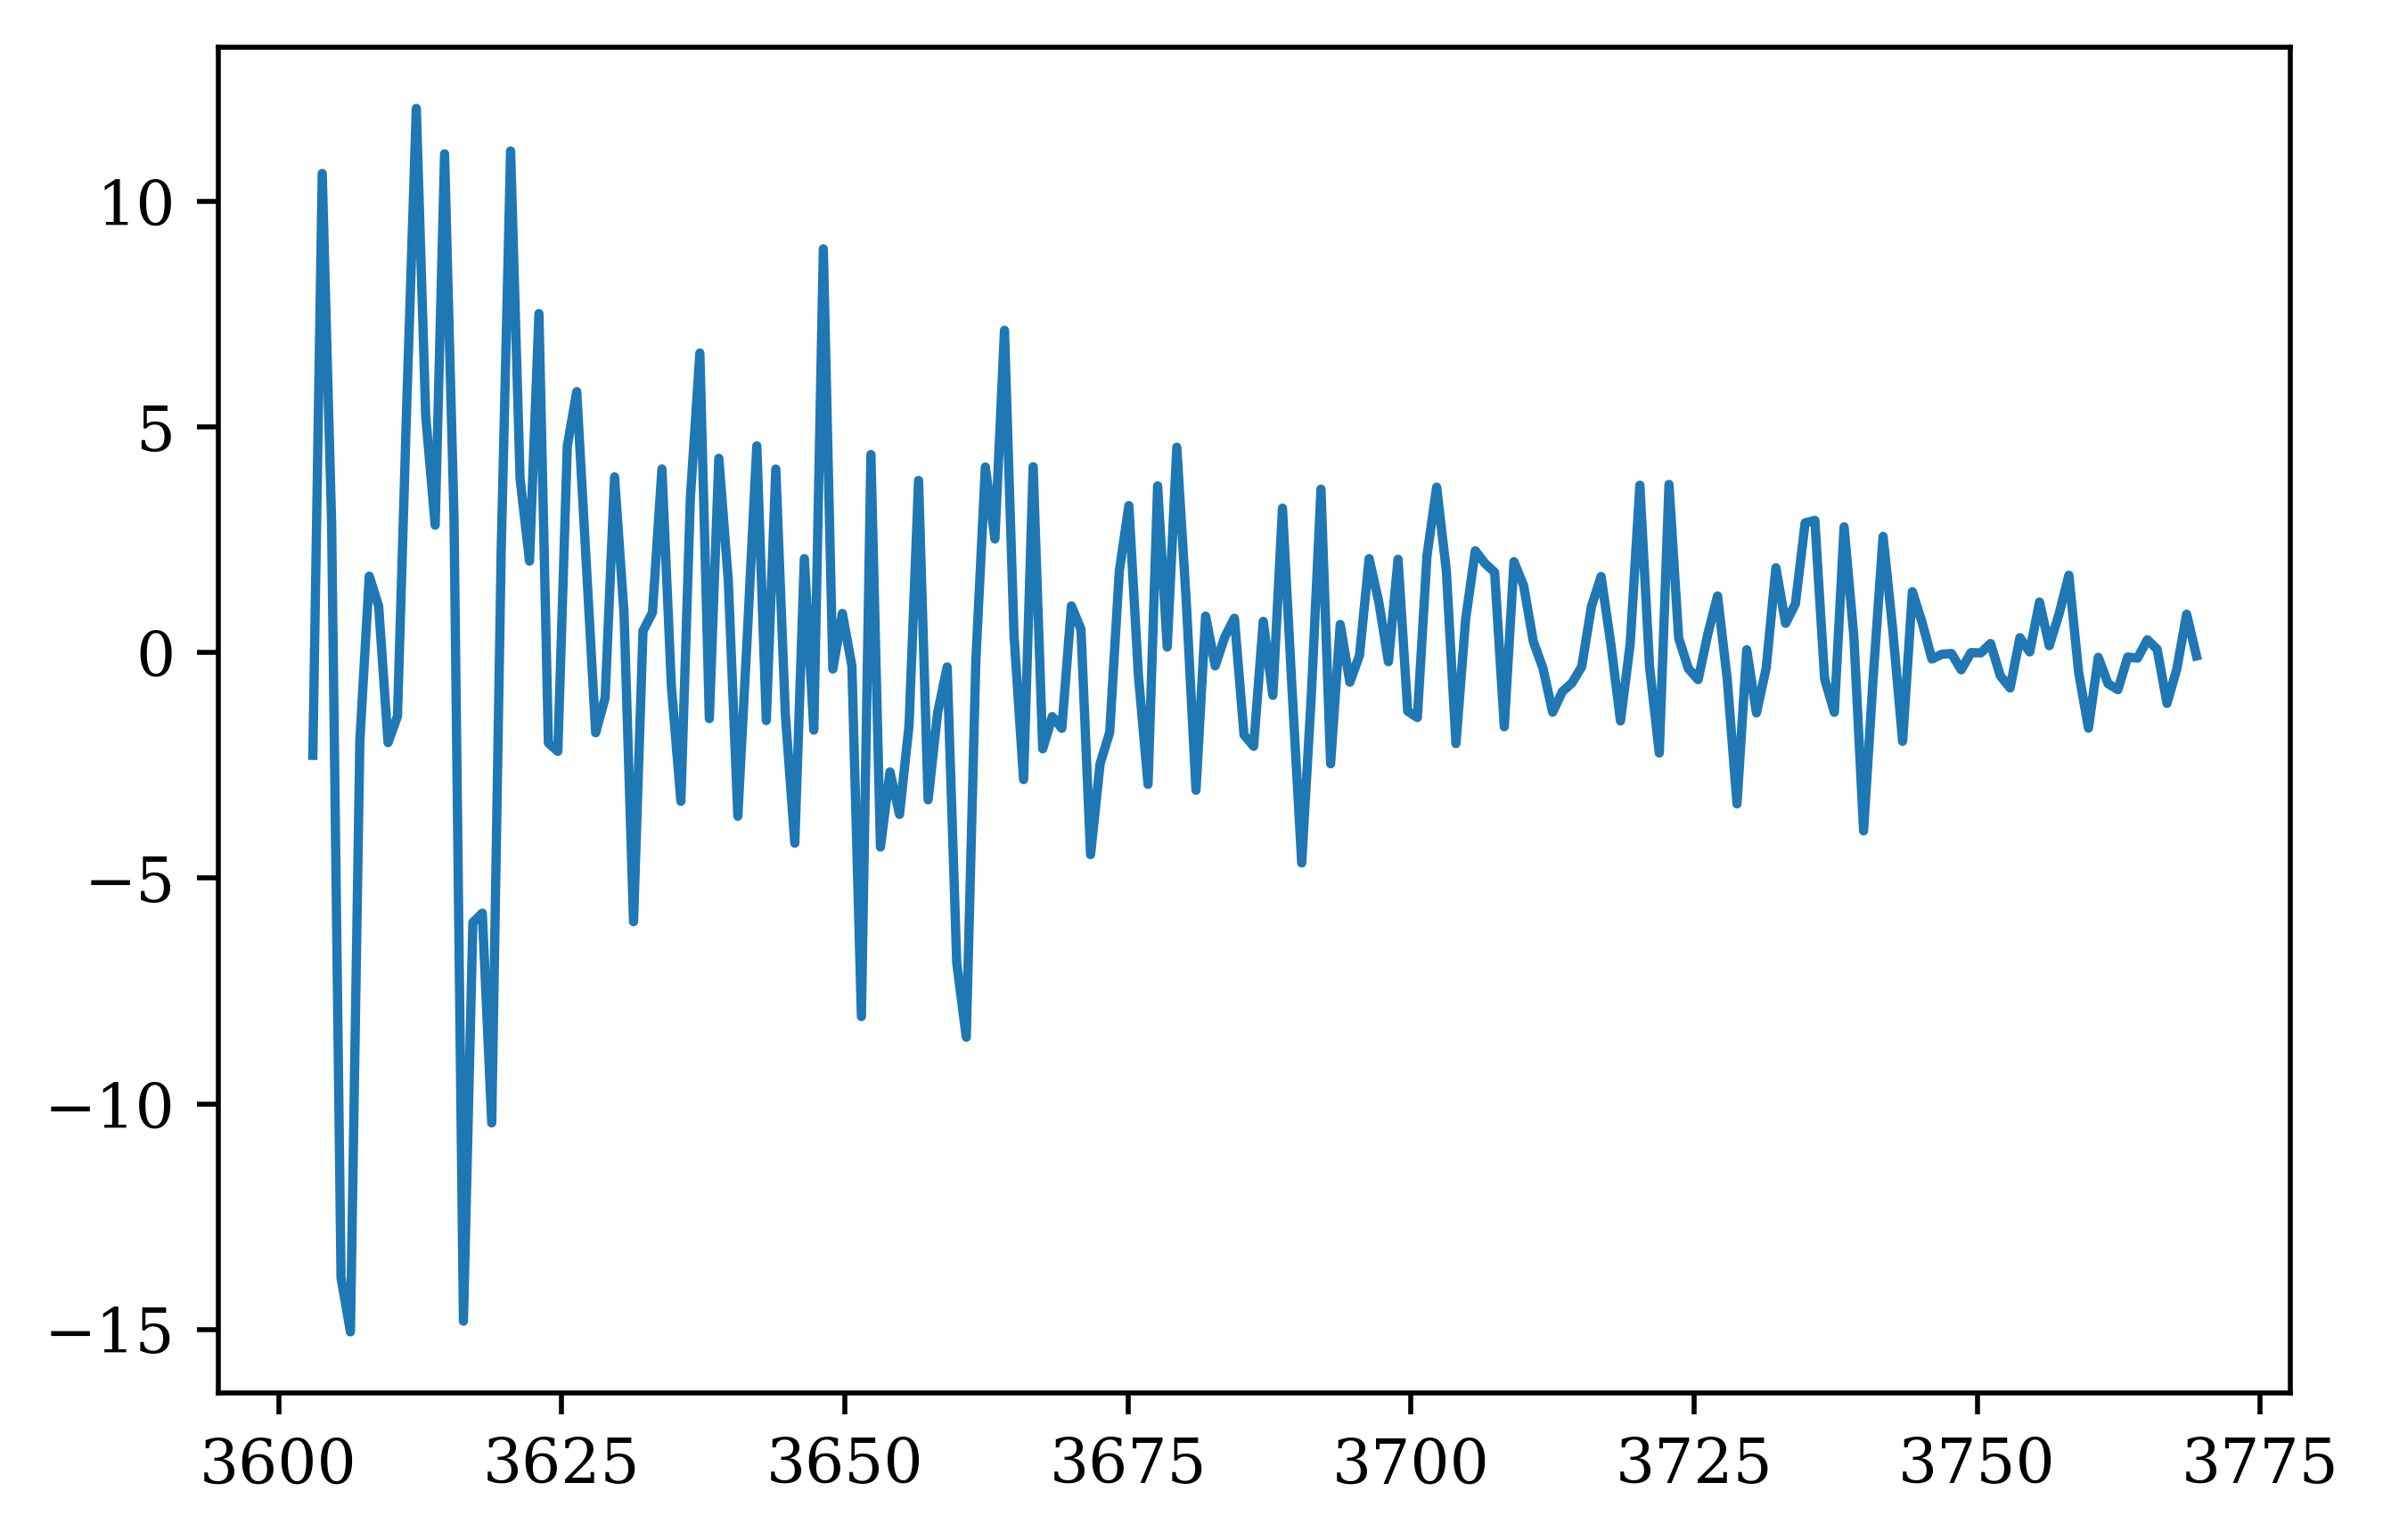

In [322]:
plt.plot(lambda_obs, deltas)
plt.show()

In [323]:
lambda_ref= 1215.67
z_add=(lambda_obs-lambda_ref)/lambda_ref

In [325]:
min(z_add)

1.963823552697221

In [326]:
max(z_add)

2.1006471363159407

In [328]:
main= fits.open('/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/delta-369.fits')

In [329]:
main[854].data

FITS_rec([(3.60116804, -6.53473570e-02, 0.73430814, -9.94802075e-01),
          (3.60126804,  2.25949466e+00, 0.64957737, -9.44545876e-01),
          (3.60136804,  2.27519356e+00, 0.62238565, -4.33562578e-01),
          (3.60146804,  1.43166793e+00, 0.66272771, -1.22061287e+00),
          (3.60156804,  4.86962857e-01, 0.69231406, -9.21249637e-01),
          (3.60166804, -6.30241177e-02, 0.70208615,  2.23451551e-01),
          (3.60176804,  2.07020344e-01, 0.6766726 , -1.13477215e+00),
          (3.60186804, -3.87014831e-01, 0.66405776,  1.24732831e+00),
          (3.60196804, -1.13512242e+00, 0.65581399,  3.59794319e+00),
          (3.60206804, -1.33598833e+00, 0.63966654,  5.63915803e-01),
          (3.60216804, -1.19116850e+00, 0.6287964 ,  7.67369808e-01),
          (3.60226804,  6.31497781e-01, 0.61965197, -1.06558262e-01),
          (3.60236804, -2.05508430e+00, 0.68678448,  3.99467922e+00),
          (3.60246804, -2.91366812e+00, 0.71963856,  1.70796099e+00),
          (3.6025680

In [330]:
main[854].header['RA']

0.335736024679684

In [331]:
main[854].header['DEC']

-0.000276526066796119

In [332]:
lambda_obs=10**(Table(main[854].data)['LOGLAM'])
len(lambda_obs)
deltas=Table(main[854].data)['DELTA']

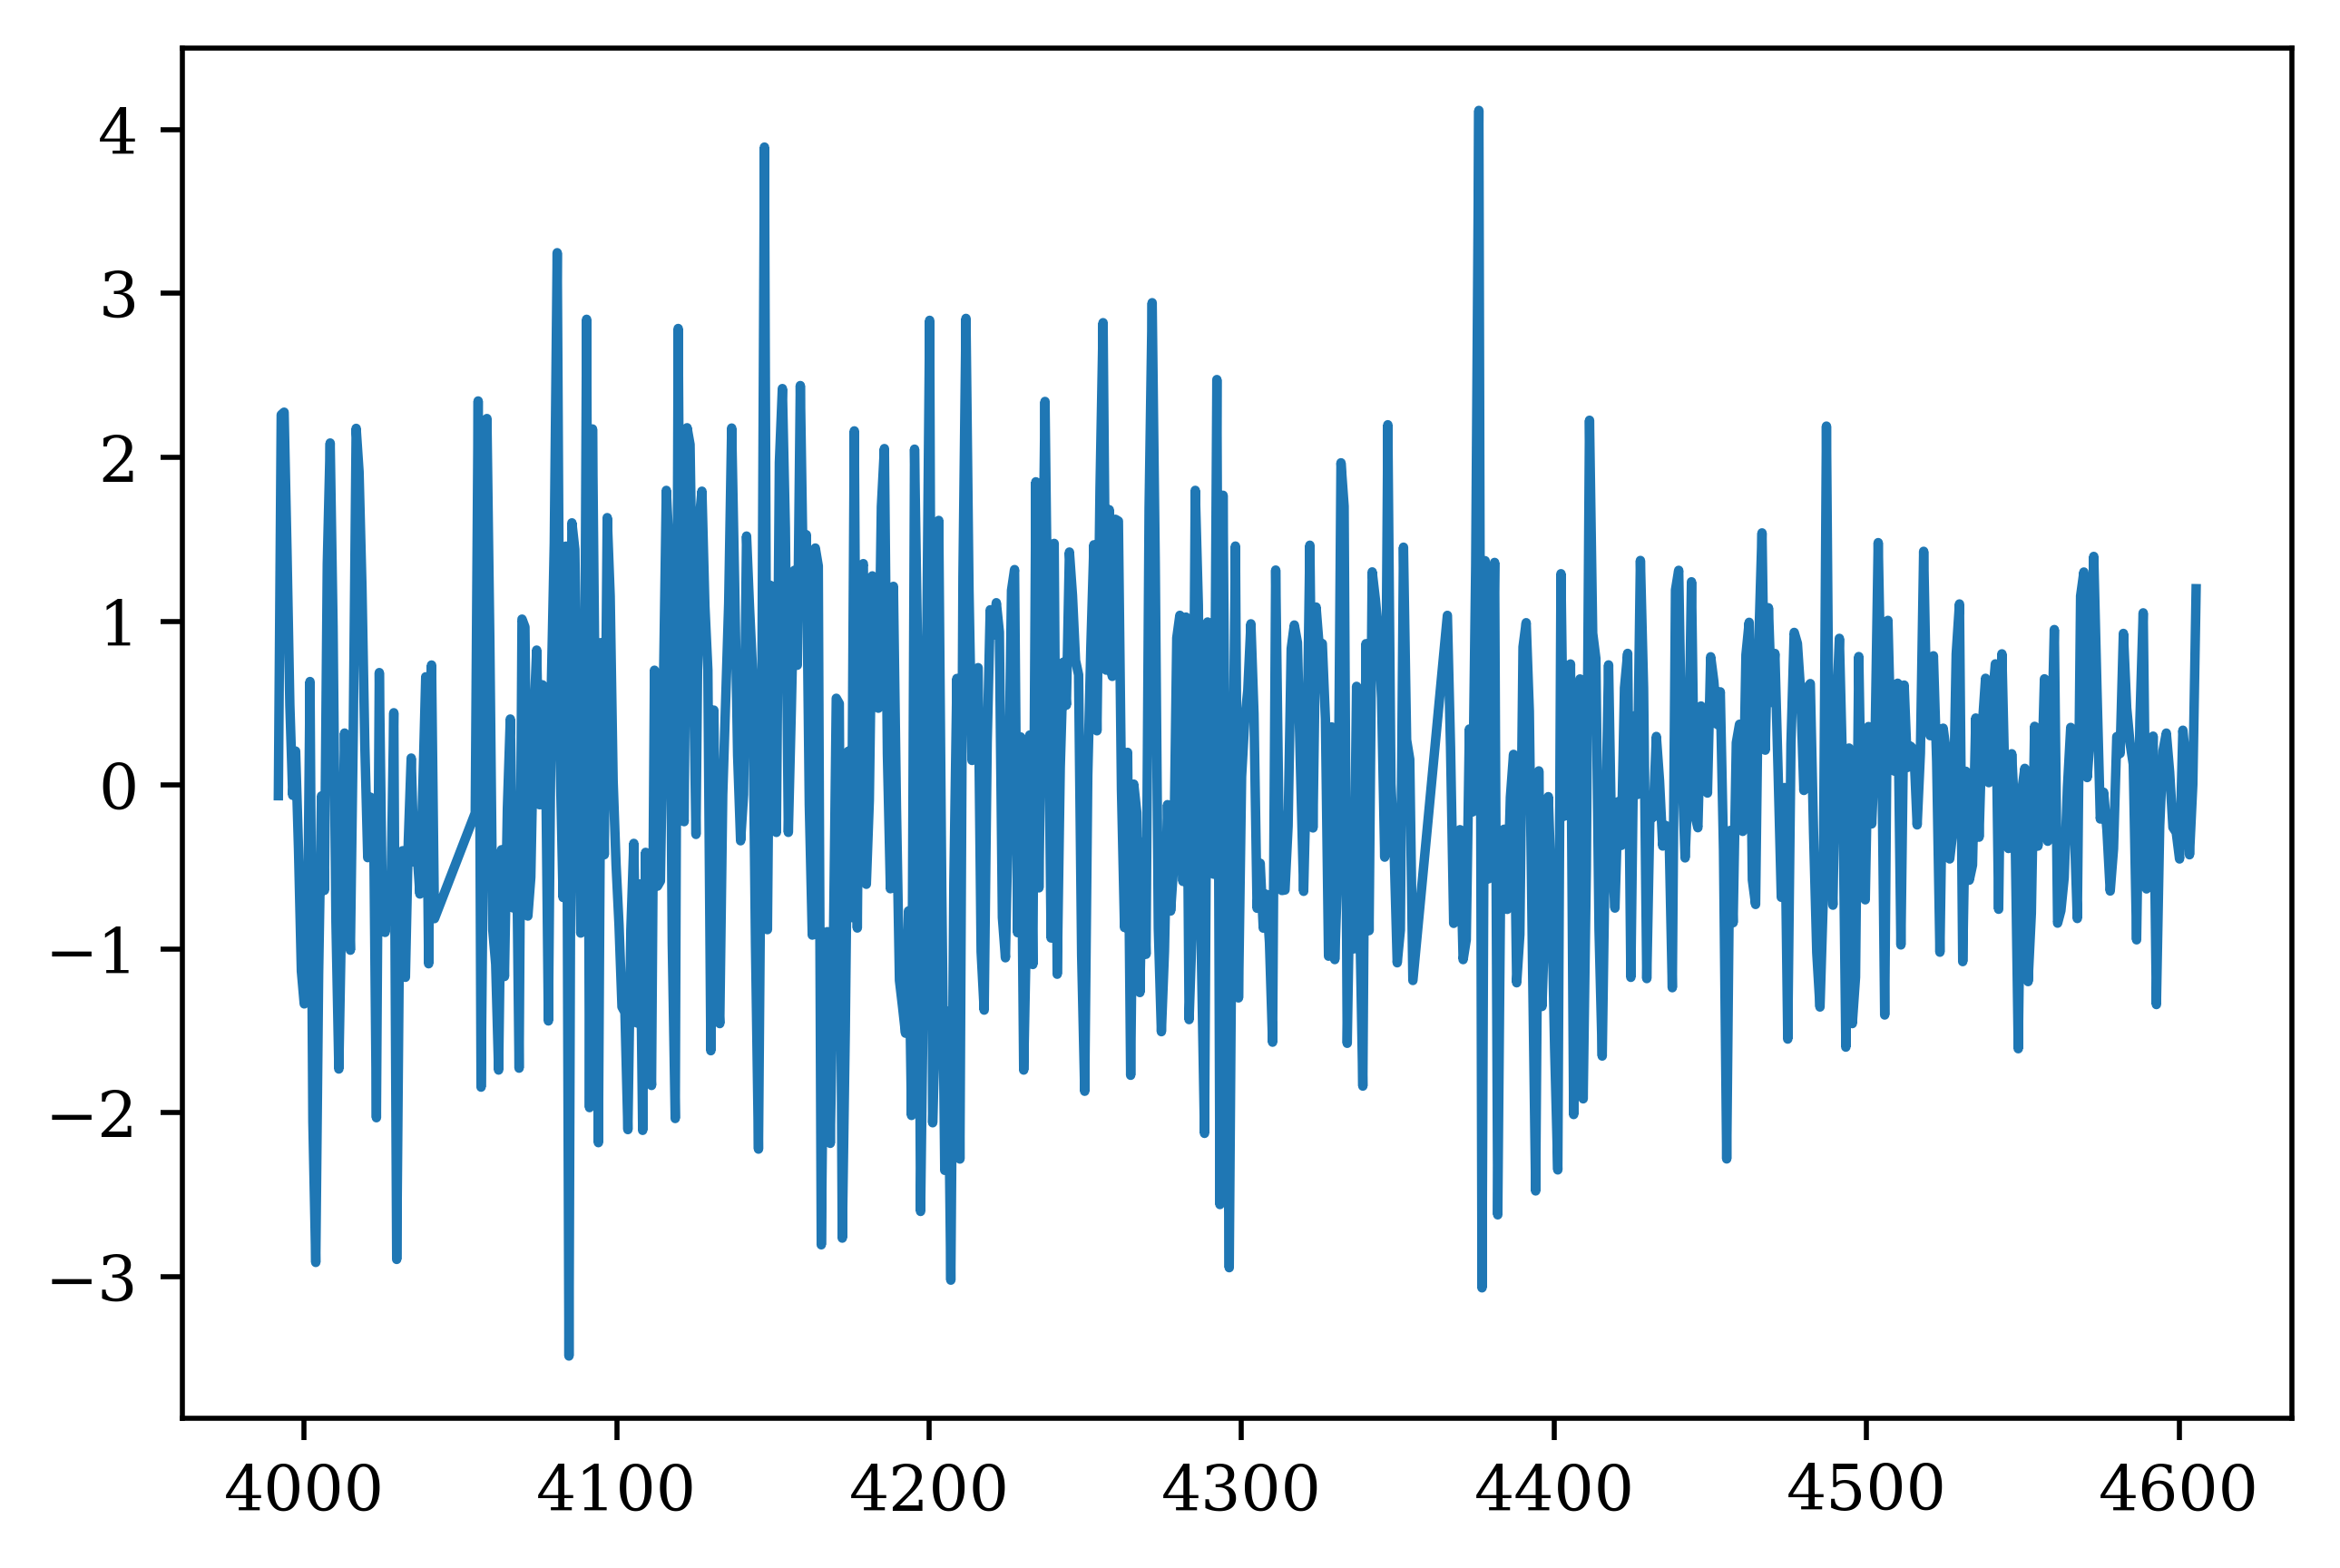

In [333]:
plt.plot(lambda_obs, deltas)
plt.show()

In [334]:
lambda_ref= 1215.67
z_add=(lambda_obs-lambda_ref)/lambda_ref

In [335]:
min(z_add)

2.2836158620557803

In [336]:
max(z_add)

2.7883696174420005

In [337]:
#402,54
main= fits.open('/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/delta-402.fits')

In [338]:
main[54].header['RA']

0.392173786128452

In [339]:
main[54].header['DEC']

-0.00229991962377061

In [340]:
lambda_obs=10**(Table(main[54].data)['LOGLAM'])
len(lambda_obs)
deltas=Table(main[54].data)['DELTA']

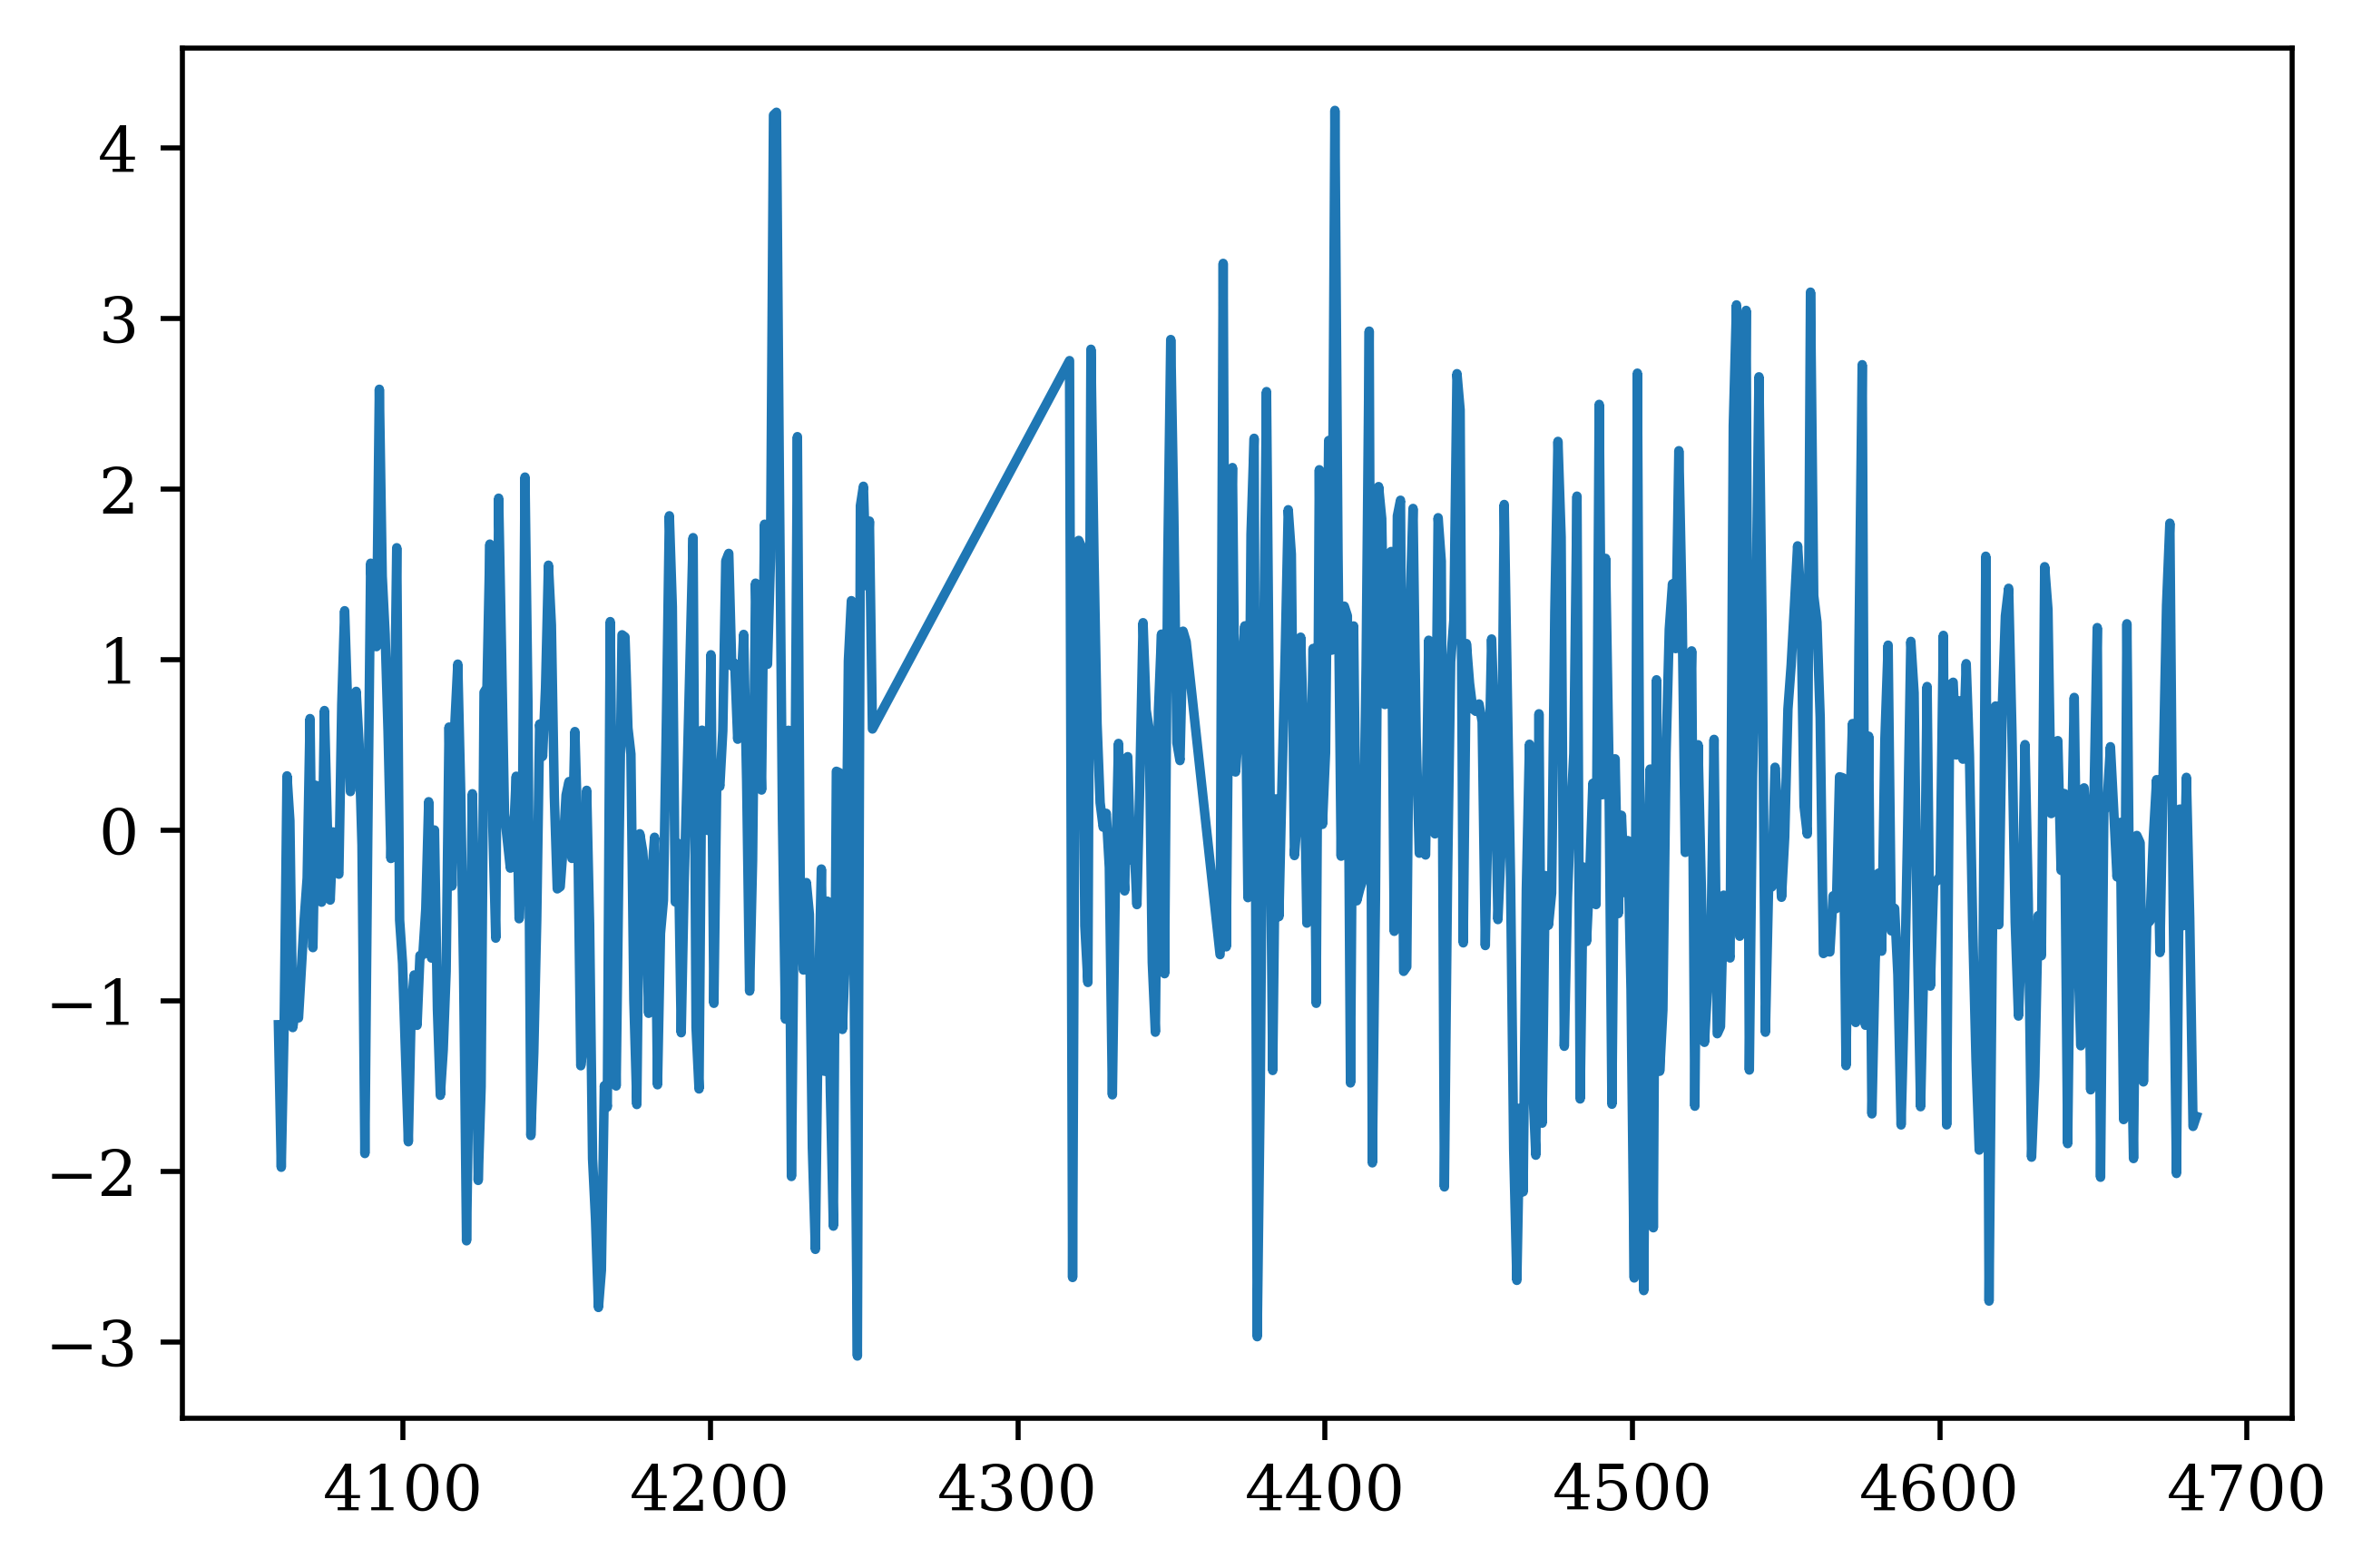

In [341]:
plt.plot(lambda_obs, deltas)
plt.show()

In [342]:
lambda_ref= 1215.67
z_add=(lambda_obs-lambda_ref)/lambda_ref

In [343]:
min(z_add)

2.3392762214791714

In [344]:
max(z_add)

2.852586025022472

In [345]:
min(galaxies['delta'])

-18291.021180129555

In [347]:
galaxies[galaxies['delta']==min(galaxies['delta'])]

<Table length=1>
         ra                 dec         ...  vflag       comoving     
      float64             float64       ... float64      float64      
------------------- ------------------- ... ------- ------------------
0.06568886154576603 -0.6958438552577206 ...     0.0 3511.4184666107517

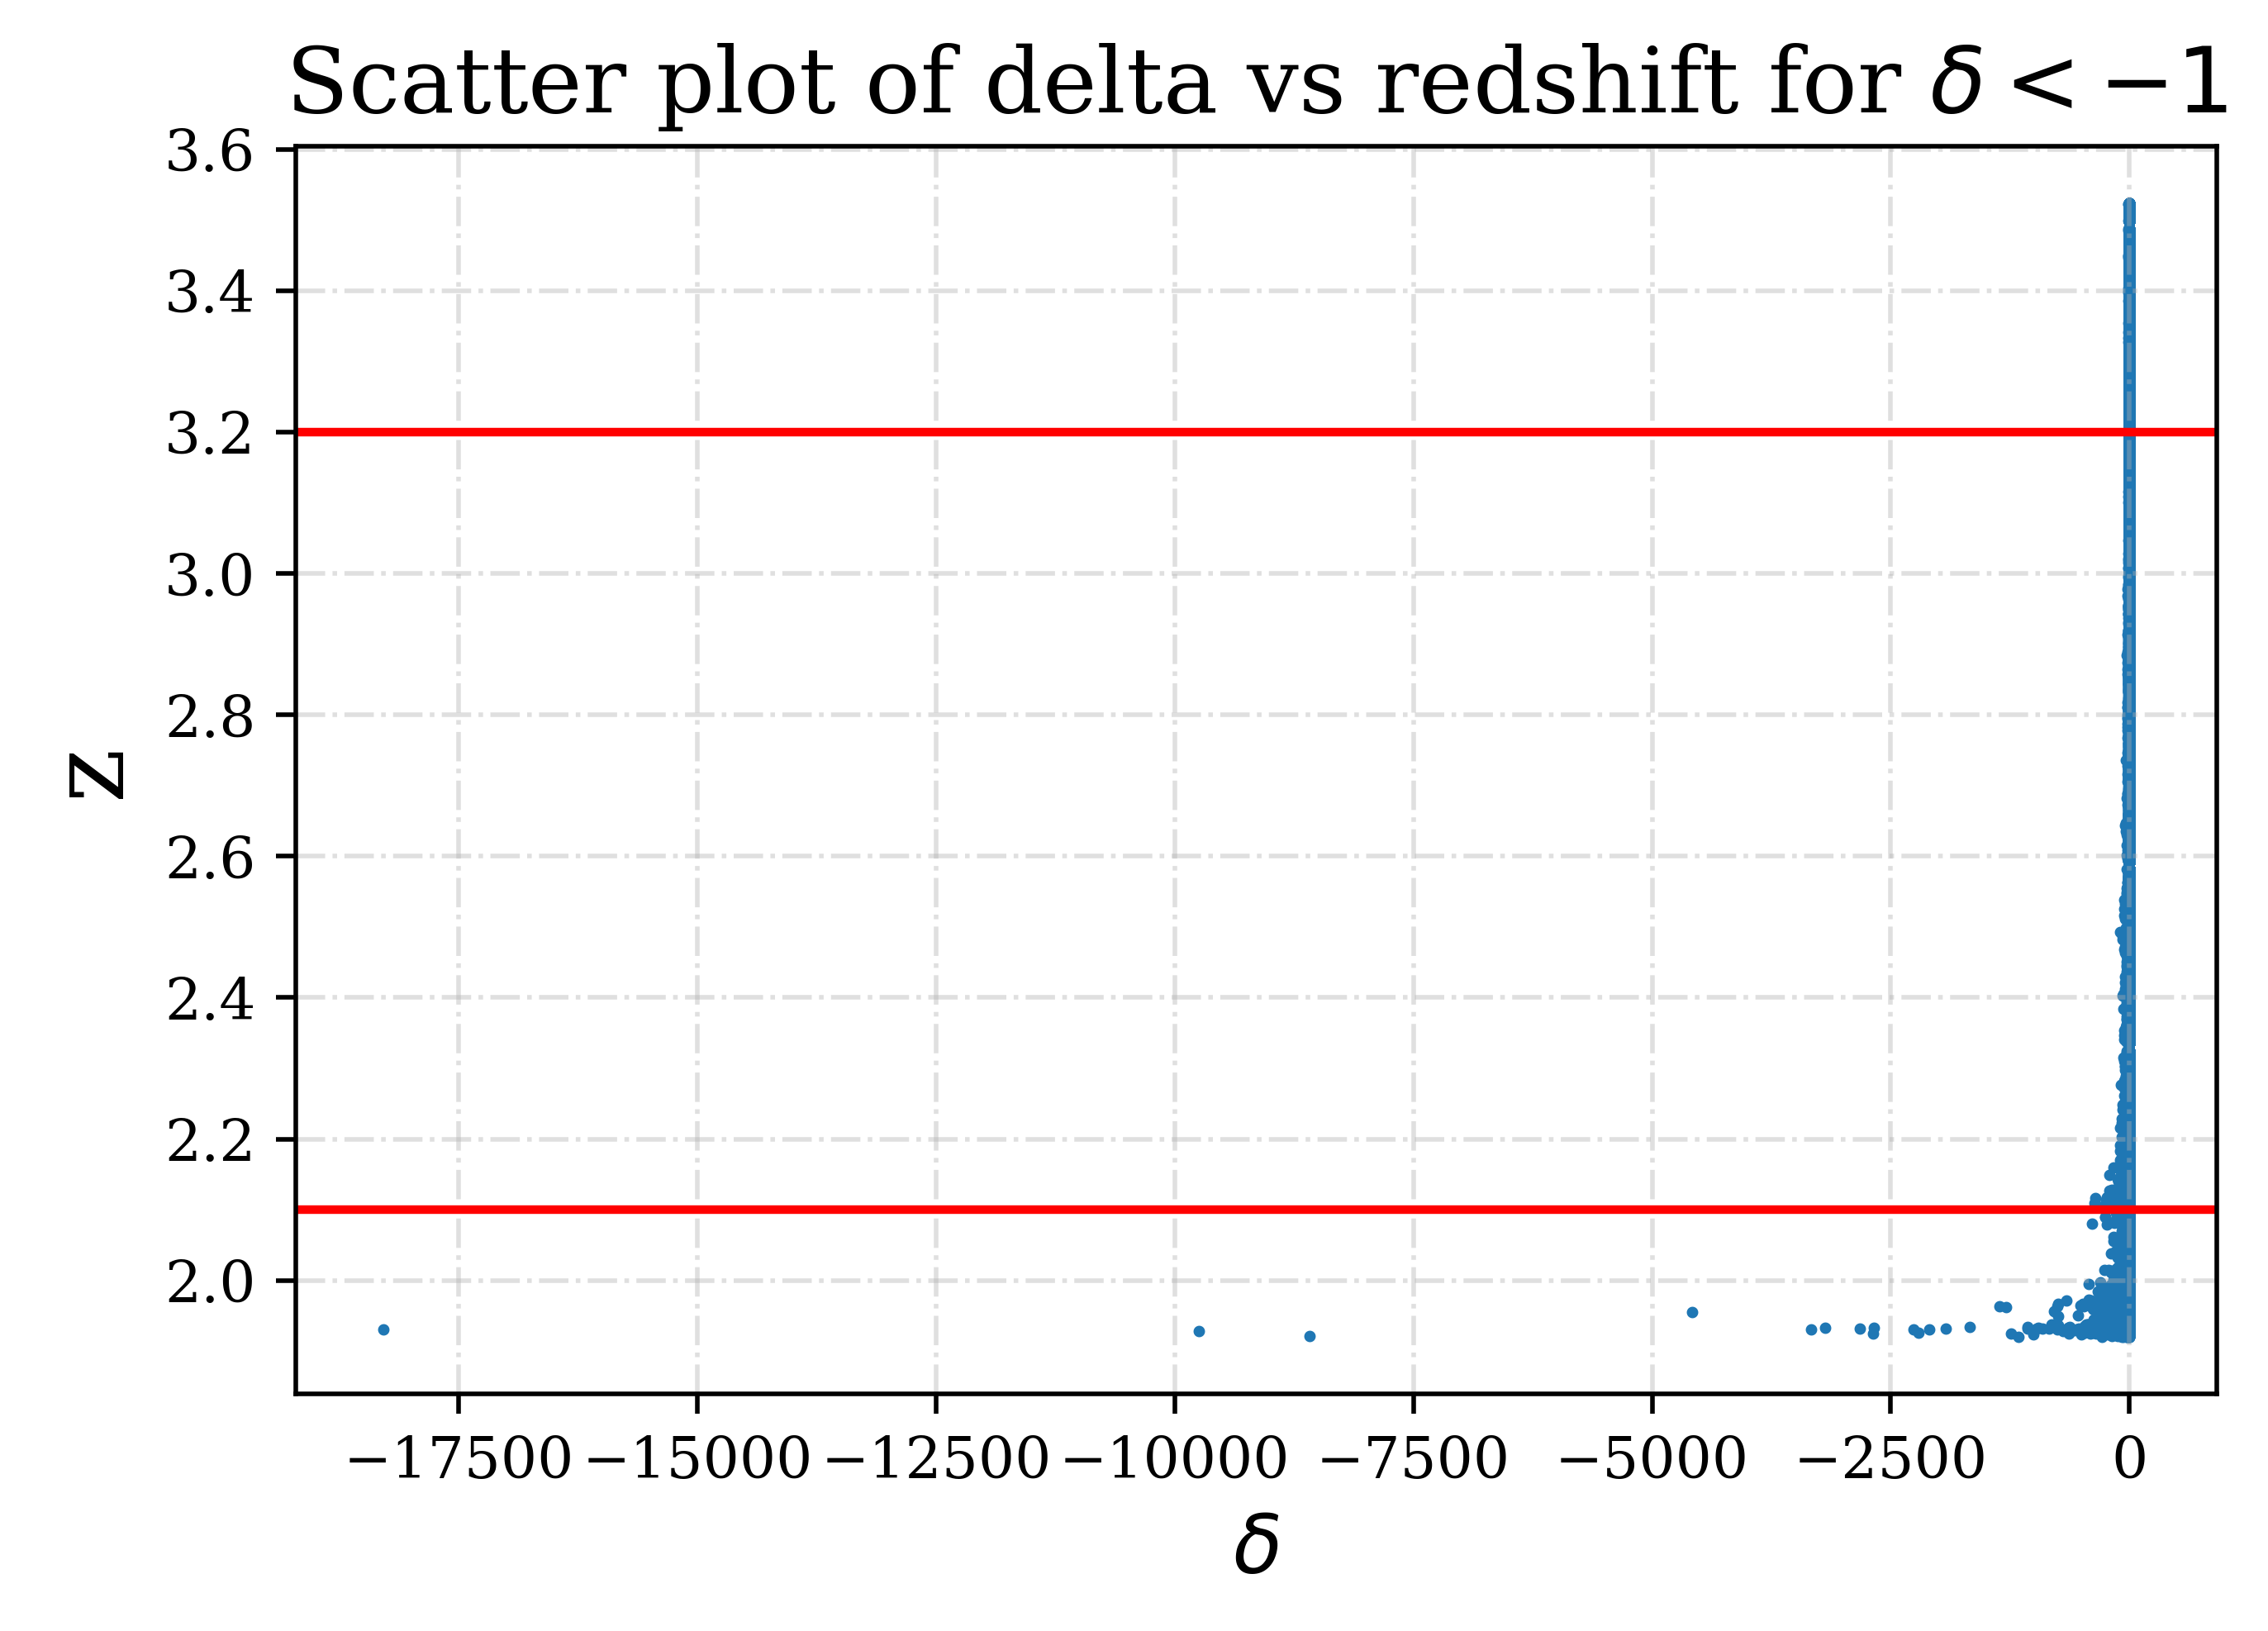

In [354]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Scatter plot of delta vs redshift for $\delta<-1$',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'z',fontsize=18)    
plt.axhline(y=2.1, color='r', linestyle='-')
plt.axhline(y=3.2, color='r', linestyle='-')
#plt.axvline(x=-1, color='r', linestyle='-')
plt.scatter(less_1['delta'], less_1['redshift'],s=1)
plt.show()

In [351]:
len(less_1)-len(less_1[less_1['redshift']<2.1])-len(less_1[less_1['redshift']>3.2])

271621

In [352]:
len(less_1)

500994

In [355]:
271621/500994

0.5421641776149015

## Are deltas for reconstructed maps also weird?

In [ ]:
recons_name='/scratch/sbenzvi_lab/boss/dr16/reconstructed_maps/data_reconstructed.fits'
recons=fits.open(recons_name) 
recons=Table(recons[1].data)

In [ ]:
recons[0:5]

In [ ]:
#Histogram of delta values
dpi=500
mpl.rcParams['figure.dpi']= dpi
plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values of reconstructed maps',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(recons['delta'] , color='teal',bins=100)                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])